# Field Potential Analysis - Chris Data Analysis
Last updated: 2025-02-06


In [21]:
# Standard library imports
import os
from pathlib import Path, PurePath
import glob
import math
import ast
import re
from typing import Literal
import warnings
import struct

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyabf
import seaborn as sns

# Scientific computing imports
from scipy import signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d, convolve1d
from scipy.signal import (
    argrelextrema,
    find_peaks,
    peak_prominences,
    resample
)
from scipy.integrate import trapezoid

In [22]:
# def savgol_filter(V, w, p, mode='nearest'):
def modified_sinc_kernel_filter(X, m=10, n=4, a=4):
    """
    Modified Sinc Kernel Filter based on Schmid et al. 2022
    """
    i = np.linspace(-m, m, 2*m+1, endpoint=True)
    x = i/(m+1)
    w = np.exp(-a * x**2) + np.exp(-a * (x+2)**2) + np.exp(-a * (x-2)**2) - 2 * np.exp(-a) - np.exp(-9 * a)
    kernel = w * np.sinc((n+4)/2 * x)
    kernel = kernel / np.sum(kernel)
    # return kernel
    return convolve1d(X, kernel, mode='nearest')

    

In [23]:
class ChrisFPAReader:
    def __init__(self, abf_folder_path, abf_subfolder):
        self.abf_folder_path = Path(abf_folder_path)
        self.abf_subfolder = abf_subfolder

    def get_abf_subfolder_items(self):
        return sorted(glob.glob(f'{self.abf_folder_path / self.abf_subfolder}/*'))
    
    def get_abf_subfolder_item_names(self):
        return [Path(i).name for i in self.get_abf_subfolder_items()]
    
    def get_abf_subfolder_num_items(self):
        return len(self.get_abf_subfolder_items())
    
    def get_abf_subfolder_subitems(self, item_name, suffix='.abf'):
        return sorted(glob.glob(f'{self.abf_folder_path / self.abf_subfolder / item_name}/*{suffix}'))

    def get_abf_subfolder_subitem_names(self, item_name, suffix='.abf'):
        return [Path(i).name for i in self.get_abf_subfolder_subitems(item_name, suffix)]
    
    def get_abf_subfolder_subitem_name(self, item_name, index, suffix='.abf'):
        return self.get_abf_subfolder_subitem_names(item_name, suffix)[index]

    def get_abf_subfolder_subitem_num_recordings(self, item_name, suffix='.abf'):
        return len(self.get_abf_subfolder_subitems(item_name, suffix))

    def get_abf_subfolder_subitem_num_sweeps(self, item_name, index):
        try:
            abf = pyabf.ABF(self.abf_folder_path / self.abf_subfolder / item_name / self.get_abf_subfolder_subitem_names(item_name)[index])
            return abf.sweepCount
        except struct.error as e:
            print(f"Error loading ABF (buffer error): {e}")
            return None

    def load_abf_all_indices(self, item_name, mode: Literal['mean', 'median'] = 'median'):
        return [self.load_abf_one_index(item_name, i, mode) for i in range(len(self.get_abf_subfolder_subitem_names(item_name)))]

    def load_abf_one_index(self, item_name, index, mode: Literal['mean', 'median', 'single'] = 'median', sweep_index=None):
        try:
            abf = pyabf.ABF(self.abf_folder_path / self.abf_subfolder / item_name / self.get_abf_subfolder_subitem_names(item_name)[index])
        except struct.error as e:
            print(f"Error loading ABF (buffer error): {e}")
            return None, None, None
        f_s = abf.sampleRate

        # Get the sweep data
        sweep_V = []
        sweep_t = []
        for i in range(abf.sweepCount):
            abf.setSweep(i)
            sweep_V.append(abf.sweepY)
            sweep_t = abf.sweepX
        
        sweep_V = np.array(sweep_V)
        sweep_t = np.array(sweep_t)
        match mode:
            case 'mean':
                sweep_V = np.mean(sweep_V, axis=0)
            case 'median':
                sweep_V = np.median(sweep_V, axis=0)
            case 'single':
                sweep_V = sweep_V[sweep_index, :]
            case _:
                raise ValueError(f"Invalid mode: {mode}")

        return sweep_V, sweep_t, f_s
    


In [24]:
class TraceFitter:
    def __init__(self, trace_V, trace_t, f_s, max_V_positive=True):
        self.trace_V = trace_V
        self.trace_t = trace_t
        self.f_s = f_s
        self.max_V_positive = max_V_positive
        if max_V_positive:
            # Find min and max of trace
            v_min = np.min(self.trace_V)
            v_max = np.max(self.trace_V)
            if v_min is None or v_max is None:
                warnings.warn("trace_V is None. Skipping negation.")
                return
            # Only negate if min is much larger than max (using absolute values). Positive stimulus
            if abs(v_min) > 3 * abs(v_max):
                self.trace_V = -self.trace_V

    def fit_trace(self):
        
        # Initialize dictionary to store fit parameters
        self.fit_params = {}

        # Save the original trace before modifications
        self.fit_params['original_trace'] = {
            'V': self.trace_V.copy(),
            't': self.trace_t.copy()
        }
        # self.apply_despiking()
        # plt.plot(self.trace_t, self.trace_V)
        # plt.show()
        self.apply_dc_filter()
        self.apply_resample()
        self.apply_edge_smoothing()
        self.apply_gaussian_lowpass()
        self.apply_trim_edge(side='right')
        self.fit_params['processed_trace'] = {
            'V': self.trace_V.copy(),
            't': self.trace_t.copy()
        }

        # Compute the spike peak index and baseline
        self.compute_spikepeak_idx()
        self.compute_baseline()
        self.fit_params['stim_onset'] = self.t_stim
        self.fit_params['stim_onset_idx'] = self.idx_stim
        self.fit_params['baseline'] = self.V_baseline
        self.fit_params['baseline_idx'] = self.idx_baseline
        self.fit_params['peak'] = self.V_peak
        self.fit_params['peak_idx'] = self.idx_peak

        # Total slope of pre-trough fEPSP
        self.compute_slope_thresholds([0, 1])
        self.compute_threshold_crossings()
        self.fit_params['total_slope'] = {
            'before': self.get_spike_slope('before', suppress_warnings=True),
            'after': self.get_spike_slope('after', suppress_warnings=True)
        }

        # 30-80 pre/post-trough, amplitude, area
        self.compute_slope_thresholds([0.3, 0.8])
        self.compute_threshold_crossings()
        self.fit_params['thresholds'] = {
            'low': self.V_threshold_low,
            'high': self.V_threshold_high
        }
        self.fit_params['30-80_slope'] = {
            'before': self.get_spike_slope('before'),
            'after': self.get_spike_slope('after')
        }
        self.fit_params['amplitude'] = self.get_amplitude()
        self.fit_params['area'] = self.get_area()
        self.fit_params['baseline_crossings'] = {
            'before_idx': self.idx_baseline_before_spike,
            'after_idx': self.idx_baseline_after_spike
        }
        
    def get_trace_fit_params(self):
        return self.fit_params

    def get_trace_fit_params_df(self):
        # Flatten nested dictionaries in fit_params
        flattened_params = {}
        for key, value in self.fit_params.items():
            if isinstance(value, dict):
                for subkey, subvalue in value.items():
                    flattened_params[f'{key}-{subkey}'] = subvalue
            else:
                flattened_params[key] = value
        return pd.DataFrame([flattened_params])
    
    def get_Ycrossings_idx(self, value, V=None):
        """
        Get the indices of the points where the value crosses some arbitrary y-value
        """
        if V is None:
            V = self.trace_V
        return np.argwhere(np.diff(np.sign(value - V))).flatten()

    def find_idx_stimulus(self, threshold):
        """
        Find the index of the first point where the value crosses the threshold
        """
        idxs = self.get_Ycrossings_idx(threshold)
        if idxs.size == 0:
            return 0
        return idxs[0]

    def apply_edge_smoothing(self, threshold=10, inplace=True):
        """
        Smooth the edges of the stimulus signal. By default modifies the trace_V in place.
        """
        if self.get_Ycrossings_idx(threshold).size == 0:
            return self.trace_V
        # The stimulus intensity increased beyond threshold
        # print("Smoothing edges of stimulus signal")
        window = np.full(self.trace_V.shape, 1.0)
        match self.get_Ycrossings_idx(threshold).size:
            case 0:
                idx_belowthresh = 0
            case 1:
                idx_belowthresh = self.get_Ycrossings_idx(threshold)[0]
            case _:
                idx_belowthresh = self.get_Ycrossings_idx(threshold)[1] # Get index of falling edge of stimulus spike; hardcoded to be the second index
        # smooth left edge
        window[:idx_belowthresh] *= np.linspace(0, 1, idx_belowthresh) 
        y_windowed = self.trace_V * window

        if inplace:
            self.trace_V = y_windowed
        return y_windowed

    def apply_despiking(self, ewma_span=10, outlier_delta=1, inplace=True):
        """
        Despike the data using an exponential weighted moving average. By default modifies the trace_V in place.
        """
        # Convert to dataframe
        df = pd.DataFrame(data=self.trace_V, columns=['raw'])
        
        # Apply exponential weighted moving average
        fwd = pd.Series.ewm(df['raw'], span=ewma_span).mean()
        bwd = pd.Series.ewm(df['raw'][::-1],span=ewma_span).mean()
        stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
        df['ewma'] = np.mean(stacked_ewma, axis=0)

        # Remove outliers, replace with NaN
        cond_delta = (np.abs(df['raw'] - df['ewma']) > outlier_delta)
        # if cond_delta.any():
        #     print("Outliers detected")
        #     print(f"Outliers: {cond_delta.sum()}")
        df['noout'] = np.where(cond_delta, np.nan, df['raw'])

        # Fill gaps with interpolation
        trace_V_despiked = df['noout'].interpolate().to_numpy()

        if inplace:
            self.trace_V = trace_V_despiked
        return trace_V_despiked

    def compute_spikepeak_idx(self, m_crude=3e-3, m_fine=1e-3, rise_threshold=30, fall_threshold=20, search_range=[0, 12e-3], maxwidth=4e-3):
    # def compute_spikepeak_idx(self, sigma_crude=1e-3, sigma_fine=5e-4, rise_threshold=10, fall_threshold=5, maxwidth=5e-3):
        """
        Find the index of the peak voltage. w1, p1, w2, p2 are the parameters for the Savitzky-Golay filter.
        rise_threshold is the threshold for the stimulus finding.
        fall_threshold is the threshold for the fall of the stimulus.
        maxwidth is the approximate width of the spike. Spikes of width 0 to maxwidth are considered.
        """

        rise_threshold = np.max(self.trace_V) * 0.5
        fall_threshold = np.max(self.trace_V) * 0.3

        if self.get_Ycrossings_idx(rise_threshold).size == 0:
            idx_start_spike = 0
            idx_peak = np.argmin(self.trace_V)
            _V_fit_lowpass = None
            _V_fit_lowpass_less = None
            _t_fit = None
        else:
            # Find where V crosses rise_threshold (going up theoretically)
            idx_start_spike = self.get_Ycrossings_idx(rise_threshold)[0]

            # Find where V then crosses fall_threshold (going down theoretically)
            temp_idxs = self.get_Ycrossings_idx(fall_threshold, V=self.trace_V[idx_start_spike:])
            if len(temp_idxs) == 0:
                # If no crossings found, don't add anything
                idx_stim_duration = 0
            else:
                # Calculate slopes at crossing points
                slopes = np.diff(self.trace_V[idx_start_spike:])[temp_idxs]
                # Find first negative slope
                neg_slopes = np.where(slopes < 0)
                if len(neg_slopes) > 0:
                    # Keep only up to first negative slope crossing
                    idx_stim_duration = temp_idxs[neg_slopes[0]][0]
                else:
                    # If no negative slopes, just take first crossing
                    idx_stim_duration = temp_idxs[0]

            idx_start_spike = int(idx_start_spike + idx_stim_duration)

            # Truncate search range to after 2ms
            idx_start_spike += round(search_range[0] * self.f_s)
            # Truncate spike to the falling side of the stimulus
            V_start_spike = self.trace_V[idx_start_spike:]
            # Truncate search range to before 15ms
            V_start_spike = V_start_spike[:round(search_range[1] * self.f_s)]


            # Perform Modified Sinc Kernel Filter to get crude approximation of spike location
            V_start_spike_lowpass = modified_sinc_kernel_filter(V_start_spike, m=round(m_crude * self.f_s), n=4, a=4)
            idxs_mincrude, props = find_peaks(-V_start_spike_lowpass, width=[0, round(maxwidth * self.f_s)])
            if len(idxs_mincrude) == 0:
                idx_mincrude = np.argmin(V_start_spike_lowpass) # Default to the lowest point
            else:
                idx_mincrude = idxs_mincrude[np.argmax(props['prominences'])]
            
            # Perform tighter Modified Sinc Kernel Filter to get nearest local minimum
            V_start_spike_lowpass_less = modified_sinc_kernel_filter(V_start_spike, m=round(m_fine * self.f_s), n=8, a=4)
            idxs_minfine, _ = find_peaks(-V_start_spike_lowpass_less, prominence=0.1)
            if len(idxs_minfine) == 0:
                idx_minfine = idx_mincrude # Default to the lowest point
            else:
                # Reject all values where V is greater than fall_threshold
                idxs_minfine = np.ma.masked_array(idxs_minfine, mask=(V_start_spike[idxs_minfine] > fall_threshold)) 
                idx_minfine = idxs_minfine[(np.abs(idxs_minfine - idx_mincrude)).argmin()]
                pass
        
            # Add back in index offset - get the index of the minimum point in the original trace
            idx_peak = idx_minfine + idx_start_spike

            _V_fit_lowpass = V_start_spike_lowpass
            _V_fit_lowpass_less = V_start_spike_lowpass_less
            _t_fit = self.trace_t[idx_start_spike:idx_start_spike + round(search_range[1] * self.f_s)]

        self.idx_stim = idx_start_spike
        self.t_stim = self.trace_t[idx_start_spike]
        self.idx_peak = idx_peak
        self.V_peak = self.trace_V[idx_peak]
        self.__V_fit_lowpass = _V_fit_lowpass
        self.__V_fit_lowpass_less = _V_fit_lowpass_less
        self.__t_fit = _t_fit

        return idx_peak
    
    def get_spikeidx_fit_params(self):
        return {
            'V_fit_lowpass': self.__V_fit_lowpass,
            'V_fit_lowpass_less': self.__V_fit_lowpass_less,
            't_fit': self.__t_fit
        }

    def apply_dc_filter(self, inplace=True):
        """
        Apply a DC filter to the trace. By default modifies the trace_V in place.
        """
        self.trace_V = self.trace_V - np.mean(self.trace_V)
        if inplace:
            self.trace_V = self.trace_V
        return self.trace_V

    def apply_gaussian_lowpass(self, sigma=3e-5, inplace=True):
        """
        Apply a Gaussian lowpass filter to the trace. By default modifies the trace_V in place. Kernel width (2*sigma) is in seconds.
        """
        y_windowed = gaussian_filter1d(self.trace_V, np.ceil(sigma * self.f_s), mode='nearest')
        if inplace:
            self.trace_V = y_windowed
        return y_windowed
    
    def apply_trim_edge(self, side='right', duration=1e-3, inplace=True):
        """
        Trim the edges of the trace. By default modifies the trace_V in place.
        """
        if side == 'right':
            trace_V_trimmed = self.trace_V[:-round(duration * self.f_s)]
            trace_t_trimmed = self.trace_t[:-round(duration * self.f_s)]
        elif side == 'left':
            trace_V_trimmed = self.trace_V[round(duration * self.f_s):]
            trace_t_trimmed = self.trace_t[round(duration * self.f_s):]
        else:
            raise ValueError(f"Invalid side: {side}. Must be 'right' or 'left'.")
        if inplace:
            self.trace_V = trace_V_trimmed
            self.trace_t = trace_t_trimmed
        return trace_V_trimmed, trace_t_trimmed
    
    def apply_resample(self, factor=4, inplace=True):
        """
        Resample the trace. By default modifies the trace_V in place.
        """
        time = len(self.trace_V) / self.f_s
        f_s_resampled = round(self.f_s * factor)
        n_new_samples = round(time * f_s_resampled)

        trace_V_resampled = resample(self.trace_V, n_new_samples)
        trace_t_resampled = np.linspace(self.trace_t[0], self.trace_t[-1], n_new_samples)
        if inplace:
            self.trace_V = trace_V_resampled
            self.trace_t = trace_t_resampled
            self.f_s = f_s_resampled
        return trace_V_resampled, trace_t_resampled, f_s_resampled
        
    def compute_baseline(self, baseline:Literal['max', 'avg']='max', search_duration=50e-3):
        """
        Compute the baseline of the trace.
        """
        if baseline == 'max':
            if search_duration is not None:
                V_base = np.max(self.trace_V[self.idx_peak:self.idx_peak + round(search_duration * self.f_s)])
                idx_base = np.argmax(self.trace_V[self.idx_peak:self.idx_peak + round(search_duration * self.f_s)])
            else:
                V_base = np.max(self.trace_V[self.idx_peak:])
                idx_base = np.argmax(self.trace_V[self.idx_peak:])
        elif baseline == 'avg':
            V_base = np.mean(self.trace_V[self.idx_peak:])
            idx_base = self.get_Ycrossings_idx(V_base)[self.get_Ycrossings_idx(V_base) > self.idx_peak][0]
        else:
            raise ValueError(f"Invalid baseline: {baseline}. Must be 'max' or 'avg'.")
        
        self.V_baseline = V_base
        self.idx_baseline = idx_base
        return V_base

    def compute_slope_thresholds(self, percentile:list[float, float]=[0.3, 0.8]):
        """
        Compute the thresholds for the slopes of the spike.
        """
        thresh_low = self.V_baseline + (self.V_peak - self.V_baseline) * percentile[0]
        thresh_high = self.V_baseline + (self.V_peak - self.V_baseline) * percentile[1]
        self.V_threshold_low = thresh_low
        self.V_threshold_high = thresh_high
        return thresh_low, thresh_high
    
    def get_area(self):
        """
        Compute the area of the spike.
        """
        # Get baseline crossings closest to peak on either side
        idxs_baseline = self.get_Ycrossings_idx(self.V_baseline)
        idxs_before = idxs_baseline[idxs_baseline < self.idx_peak]
        idxs_after = idxs_baseline[idxs_baseline > self.idx_peak]
        
        if len(idxs_before) == 0:
            warnings.warn("Could not find baseline crossings before peak. Using max before peak")
            idxs_before = [np.argmax(self.trace_V[:self.idx_peak])]
        if len(idxs_after) == 0:
            warnings.warn("Could not find baseline crossings after peak. Using max after peak")
            idxs_after = [np.argmax(self.trace_V[self.idx_peak:])]

        # if len(idxs_before) == 0 or len(idxs_after) == 0:
        #     warnings.warn("Could not find baseline crossings on both sides of peak. Returning 0")
        #     area = 0
        # else:
        #     idx_before = idxs_before[np.argmax(idxs_before)]  # rightmost crossing before peak
        #     idx_after = idxs_after[np.argmin(idxs_after)]    # leftmost crossing after peak

        idx_before = idxs_before[np.argmax(idxs_before)]
        idx_after = idxs_after[np.argmin(idxs_after)]
        self.idx_baseline_before_spike = idx_before
        self.idx_baseline_after_spike = idx_after

        # Using Tai's AUC model
        area = trapezoid(self.trace_V[idx_before:idx_after], self.trace_t[idx_before:idx_after])
        return area

    def compute_threshold_crossings(self):
        """
        Compute the indices of the threshold crossings.
        """
        idx_crossings_low = self.get_Ycrossings_idx(self.V_threshold_low)
        idx_crossings_high = self.get_Ycrossings_idx(self.V_threshold_high)

        self.idx_crossings_low = idx_crossings_low
        self.idx_crossings_high = idx_crossings_high
        self.V_crossings_low = self.trace_V[idx_crossings_low]
        self.V_crossings_high = self.trace_V[idx_crossings_high]

        return idx_crossings_low, idx_crossings_high

    def _get_threshold_crossings_near_spike(self, side:Literal['before', 'after'], suppress_warnings=False):
        """
        Get the indices of the threshold crossings near the spike.
        """
        # Filter for crossings before peak and sort by distance to peak
        if side == 'before':
            idx_low_near = self.idx_crossings_low[self.idx_crossings_low <= self.idx_peak] # before peak
            idx_high_near = self.idx_crossings_high[self.idx_crossings_high <= self.idx_peak] # before peak
        elif side == 'after':
            idx_low_near = self.idx_crossings_low[self.idx_crossings_low >= self.idx_peak] # after peak
            idx_high_near = self.idx_crossings_high[self.idx_crossings_high >= self.idx_peak] # after peak
        else:
            raise ValueError(f"Invalid side: {side}. Must be 'before' or 'after'.")

        # Sort by distance to peak (closest first)
        idx_low_near = idx_low_near[np.argsort(np.abs(self.idx_peak - idx_low_near))]
        idx_high_near = idx_high_near[np.argsort(np.abs(self.idx_peak - idx_high_near))]

        if not idx_low_near.any():
            if not suppress_warnings:
                warnings.warn(f"No low crossings {side} spike. Using baseline")
            idx_low_near = [self.idx_baseline]
        if not idx_high_near.any():
            if not suppress_warnings:
                warnings.warn(f"No high crossings {side} spike. Using peak")
            idx_high_near = [self.idx_peak]
        
        return idx_low_near, idx_high_near

    def get_spike_slope(self, side:Literal['before', 'after'], suppress_warnings=False):
        """
        Compute the slope of the spike.
        """
        idx_low, idx_high = self._get_threshold_crossings_near_spike(side=side, suppress_warnings=suppress_warnings)
        idx_low = idx_low[0]
        idx_high = idx_high[0]

        idx1 = min(idx_low, idx_high)
        idx2 = max(idx_low, idx_high)
        
        return (self.trace_V[idx2] - self.trace_V[idx1]) / ((idx2 - idx1) / self.f_s)

    def get_amplitude(self):
        """
        Compute the amplitude of the spike.
        """
        V_amplitude = self.V_peak - self.V_baseline
        return V_amplitude





In [25]:
class SlicePlotter:
    def __init__(self, abf_folder_path:Path, abf_subfolder:str, compute_single_sweeps=False, y_rec_spacing=10, y_sweep_spacing=5, auto_ylim_margin=50, cmap=plt.cm.viridis, savepath=None):
        self.abf_folder_path = abf_folder_path
        self.abf_subfolder = abf_subfolder
        self.cf = ChrisFPAReader(abf_folder_path, abf_subfolder)
        self.subfolder_item_names = self.cf.get_abf_subfolder_item_names()
        self.compute_single_sweeps = compute_single_sweeps
        self._mode = 'mean' if not compute_single_sweeps else 'single'
        self.y_rec_spacing = y_rec_spacing
        self.y_sweep_spacing = y_sweep_spacing
        self.cmap = cmap
        self.savepath = Path(savepath) if savepath is not None else None
        self.auto_ylim_margin = auto_ylim_margin
    def __check_has_subfolder_item(self, item_name):
        if item_name not in self.subfolder_item_names:
            warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
            return False
        return True

    def __plot_one_trace(self, tf:TraceFitter, color, ax, y_offset=0, x_offset=0, y_label=None, label_x_offset=0, plot_area=True, plot_spikefit_curves=True, align_stim=False):
        if tf.trace_V is None and tf.trace_t is None and tf.f_s is None:
            ax.axhline(y=y_offset, color='red', linestyle='--', alpha=0.3)
            warnings.warn("V, t, and f_s are None. Skipping trace.")
            return pd.DataFrame()
        
        tf.fit_trace()
        out = tf.get_trace_fit_params()
        out_row = tf.get_trace_fit_params_df()
        peak_idx = out['peak_idx']
        V = out['processed_trace']['V'] + y_offset
        t = out['processed_trace']['t'] + x_offset
        stim_offset_t = -out['stim_onset'] if align_stim else 0 # align stim to 0
        t = t + stim_offset_t
        
        if y_label is not None:
            if not align_stim:
                ax.text(t[0], V[0], y_label, 
                        verticalalignment='center', horizontalalignment='right')
            else:
                ax.text(label_x_offset, V[0], y_label, 
                        verticalalignment='center', horizontalalignment='right')
        
        ax.plot(t, V, color=color)
        ax.plot(t[peak_idx], V[peak_idx], 'ro', label='Peak')
        for side in ['before', 'after']:
            idx1, idx2 = tf._get_threshold_crossings_near_spike(side)
            idx1, idx2 = idx1[0], idx2[0]
            ax.plot([t[idx1], t[idx2]], np.array([V[idx1], V[idx2]]), c='C1', label=f'{side} slope')
        if plot_area:
            before_idx1 = tf.get_trace_fit_params()['baseline_crossings']['before_idx']
            after_idx1 = tf.get_trace_fit_params()['baseline_crossings']['after_idx']
            baseline = out['baseline'] + y_offset
            ax.fill_between(t[before_idx1:after_idx1], baseline, V[before_idx1:after_idx1], color=color, alpha=0.3)
        if plot_spikefit_curves:
            out_si = tf.get_spikeidx_fit_params()
            if all(v is not None for v in out_si.values()):
                ax.plot(out_si['t_fit'] + x_offset + stim_offset_t, out_si['V_fit_lowpass'] + y_offset, c='red', label='Spike fitting curve', alpha=0.2)
            
        
        return out_row
    
    def __compute_offset(self, item_name, idx_rec, idx_sweep):
        offset = 0
        for i in range(idx_rec):
            n_sweeps = self.__get_n_sweeps(item_name, i)
            offset += (n_sweeps - 1) * self.y_sweep_spacing + self.y_rec_spacing
        offset += idx_sweep * self.y_sweep_spacing
        return offset

    def __get_n_sweeps(self, item_name, i):
        if self.compute_single_sweeps:
            n_sweeps = self.cf.get_abf_subfolder_subitem_num_sweeps(item_name, i)
        else:
            n_sweeps = 1
        return n_sweeps if n_sweeps is not None else 1
        
    def __compute_ylim_auto(self, item_name, n_recordings, n_sweeps):
        offset = self.__compute_offset(item_name, n_recordings - 1, n_sweeps - 1)
        ylim = (-self.auto_ylim_margin, offset + self.auto_ylim_margin)
        return ylim

    def __get_plot_color(self, i, n_recordings):
        return self.cmap(i/(n_recordings - 1)) if n_recordings > 1 else self.cmap(0.5)

    def compute_all_io(self, ylim='auto', figsize=(7, 5)):

        if not self.__check_has_subfolder_item('I-O'):
            return
        
        n_recordings = self.cf.get_abf_subfolder_subitem_num_recordings('I-O')
        
        fit_params = []
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        for i in range(n_recordings):
            n_sweeps = self.__get_n_sweeps('I-O', i)
            for j in range(n_sweeps):
                V, t, f_s = self.cf.load_abf_one_index('I-O', i, mode=self._mode, sweep_index=j)
                subitem_name = self.cf.get_abf_subfolder_subitem_name('I-O', i)
                y_label = f'{subitem_name} #{j}' if self.compute_single_sweeps else subitem_name

                offset = self.__compute_offset('I-O', i, j)
                color = self.__get_plot_color(i, n_recordings)
                out_row = self.__plot_one_trace(TraceFitter(V, t, f_s), color, ax, offset, y_label=y_label)
                
                out_row['recording_name'] = subitem_name
                out_row['recording_index'] = i
                out_row['sweep_index'] = j
                fit_params.append(out_row)
        
        self.df_io = pd.concat(fit_params, ignore_index=True)

        self.__plot_figure_settings('I-O', fig, ax, n_recordings, n_sweeps, 'IO Curves', ylim)
        if self.savepath is not None:
            plt.savefig(self.savepath / 'io.png', bbox_inches='tight')
        plt.show()

    def __plot_figure_settings(self, item_name, fig, ax, n_recordings, n_sweeps, title, ylim, xlim=(0, 0.024), show_colorbar=True):
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=self.cmap, norm=plt.Normalize(0, n_recordings-1))
        if show_colorbar:
            cax = fig.add_axes([0.2, 0, 0.6, 0.03])  # [left, bottom, width, height]
            cbar = fig.colorbar(sm, cax=cax, label='Recording Index', orientation='horizontal')
            cbar.ax.set_box_aspect(0.05)  # Reduce the height of the colorbar
        ax.set_title(f'{self.abf_subfolder} {title}')
        ax.set_xlim(xlim)
        ax.set_xlabel('Time (s)')
        ax.set_ylim(ylim if ylim != 'auto' else self.__compute_ylim_auto(item_name, n_recordings, n_sweeps))
        ax.set_ylabel('Voltage (mV)')
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
    
    def compute_all_bl(self, ylim='auto', figsize=(7, 3)):
        if not self.__check_has_subfolder_item('BL'):
            return
        
        fit_params = []
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        n_sweeps = self.__get_n_sweeps('BL', 0)
        for j in range(n_sweeps):
            V, t, f_s = self.cf.load_abf_one_index('BL', 0, mode=self._mode, sweep_index=j)

            offset = self.__compute_offset('BL', 0, j)
            color = self.__get_plot_color(j, n_sweeps)
            out_df = self.__plot_one_trace(TraceFitter(V, t, f_s), color, ax, offset, y_label=f'#{j}')

            out_df['recording_name'] = self.cf.get_abf_subfolder_subitem_name('BL', 0)
            out_df['recording_index'] = 0
            out_df['sweep_index'] = j
            fit_params.append(out_df)

        self.df_bl = pd.concat(fit_params, ignore_index=True)

        self.__plot_figure_settings('BL', fig, ax, 1, n_sweeps, 'BL Curve', ylim, show_colorbar=False)
        if self.savepath is not None:
            plt.savefig(self.savepath / 'bl.png', bbox_inches='tight')
        plt.show()


    def compute_all_post_ltp(self, ylim='auto', figsize=(7, 3)):
        if not self.__check_has_subfolder_item('Post LTP'):
            return
        
        n_recordings = self.cf.get_abf_subfolder_subitem_num_recordings('Post LTP')

        fit_params = []
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        for i in range(n_recordings):
            n_sweeps = self.__get_n_sweeps('Post LTP', i)
            for j in range(n_sweeps):
                V, t, f_s = self.cf.load_abf_one_index('Post LTP', i, mode=self._mode, sweep_index=j)
                subitem_name = self.cf.get_abf_subfolder_subitem_name('Post LTP', i)
                y_label = f'{subitem_name} #{j}' if self.compute_single_sweeps else subitem_name
                offset = self.__compute_offset('Post LTP', i, j)
                color = self.__get_plot_color(i, n_recordings)
                out_row = self.__plot_one_trace(TraceFitter(V, t, f_s), color, ax, offset, y_label=y_label)

                out_row['recording_name'] = subitem_name
                out_row['recording_index'] = i
                out_row['sweep_index'] = j
                fit_params.append(out_row)

        self.df_post_ltp = pd.concat(fit_params, ignore_index=True)

        self.__plot_figure_settings('Post LTP', fig, ax, n_recordings, n_sweeps, 'Post LTP Curve', ylim)
        if self.savepath is not None:
            plt.savefig(self.savepath / 'post_ltp.png', bbox_inches='tight')
        plt.show()

    
    def compute_all_ppr(self, item_name:Literal['Pre PP', 'Post PP'], xlim=(-0.005, 0.024), ylim='auto', figsize=(7, 3)):
        if not self.__check_has_subfolder_item(item_name):
            return
        
        n_recordings = self.cf.get_abf_subfolder_subitem_num_recordings(item_name)

        fit_params = []

        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
        axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

        # fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True, sharex=True)
        for i in range(n_recordings):
            n_sweeps = self.__get_n_sweeps(item_name, i)
            for j in range(n_sweeps):
                V, t, f_s = self.cf.load_abf_one_index(item_name, i, mode=self._mode, sweep_index=j)
                subitem_name = self.cf.get_abf_subfolder_subitem_name(item_name, i)
                y_label = f'{subitem_name} #{j}' if self.compute_single_sweeps else subitem_name

                # Find average of indices that cross threshold
                stim_threshold = (np.max(V) + np.min(V)) / 2
                idx_crossings = np.argwhere(np.diff(np.sign(V - stim_threshold))).flatten()
                idx_avg = int(np.average(idx_crossings))

                # Cut recording in half
                if not np.isnan(idx_avg):
                    V_1 = V[:idx_avg]
                    t_1 = t[:idx_avg]
                    V_2 = V[idx_avg:]
                    t_2 = t[idx_avg:]

                offset = self.__compute_offset(item_name, i, j)
                color = self.__get_plot_color(i, n_recordings)
                out_row1 = self.__plot_one_trace(TraceFitter(V_1, t_1, f_s), color, axes[0], y_offset=offset, x_offset=0, y_label=y_label, label_x_offset=-0.005, align_stim=True)
                out_row1['recording_name'] = subitem_name
                out_row1['recording_index'] = i
                out_row1['sweep_index'] = j
                out_row1['pulse'] = 1
                fit_params.append(out_row1)

                out_row2 = self.__plot_one_trace(TraceFitter(V_2, t_2, f_s), color, axes[1], y_offset=offset, x_offset=0, y_label=None, label_x_offset=-0.005, align_stim=True)
                out_row2['recording_name'] = subitem_name
                out_row2['recording_index'] = i
                out_row2['sweep_index'] = j
                out_row2['pulse'] = 2
                fit_params.append(out_row2)

        if item_name == 'Pre PP':
            self.df_pre_ppr = pd.concat(fit_params, ignore_index=True)
        else:
            self.df_post_ppr = pd.concat(fit_params, ignore_index=True)

        self.__plot_figure_settings(item_name, fig, axes[0], n_recordings, n_sweeps, f'{item_name} Curve', ylim, xlim, show_colorbar=False)
        self.__plot_figure_settings(item_name, fig, axes[1], n_recordings, n_sweeps, f'{item_name} Curve', ylim, xlim, show_colorbar=True)
        if self.savepath is not None:
            filename = item_name.lower().replace(' ', '_') + '.png'
            plt.savefig(self.savepath / filename, bbox_inches='tight')
        plt.show()


In [26]:
folders = [Path(x).name for x in glob.glob('/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/LTP & IO/*')]
print(folders)
plt.close('all')


['22518000', '23420034', '23627000', '24205000', '23420000', '24305000', '24220000', '23613000', '23614045', '24213000', '23524000', '23420015', '23420042', '23602000', '23601000', '23601040', '23628000', '23829000', '23830000']


In [27]:
# %matplotlib widget

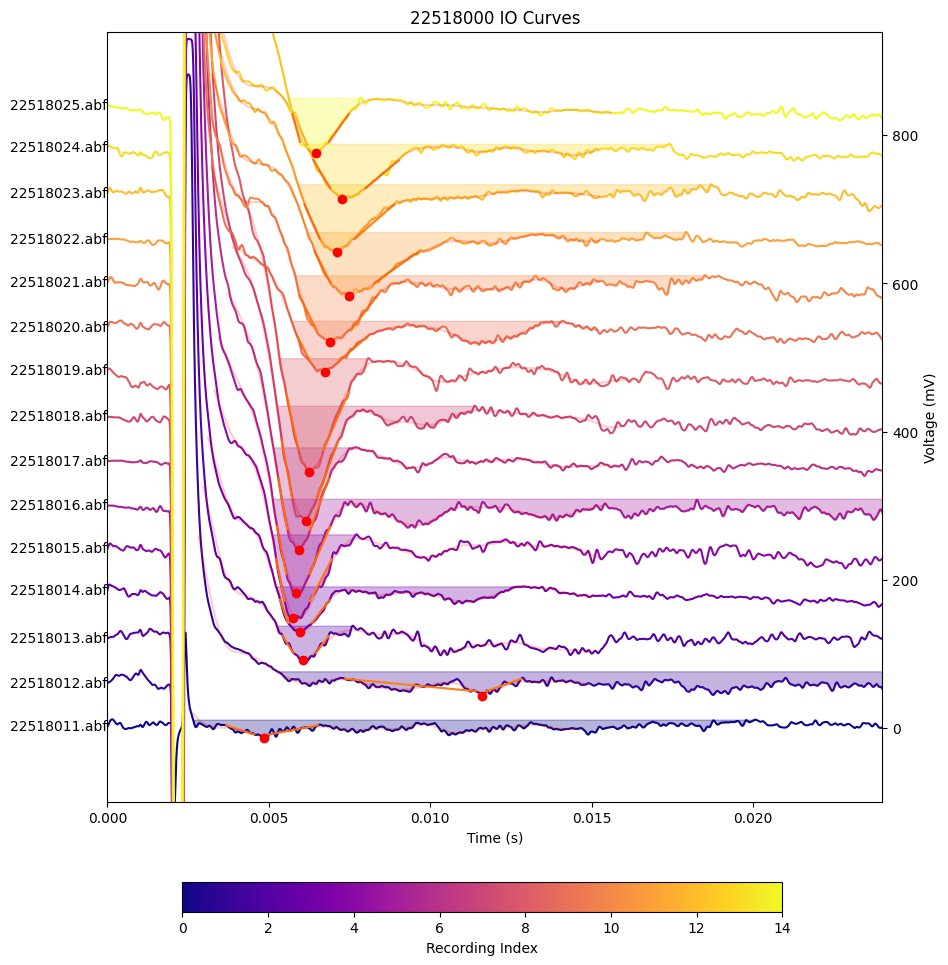

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No BL recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


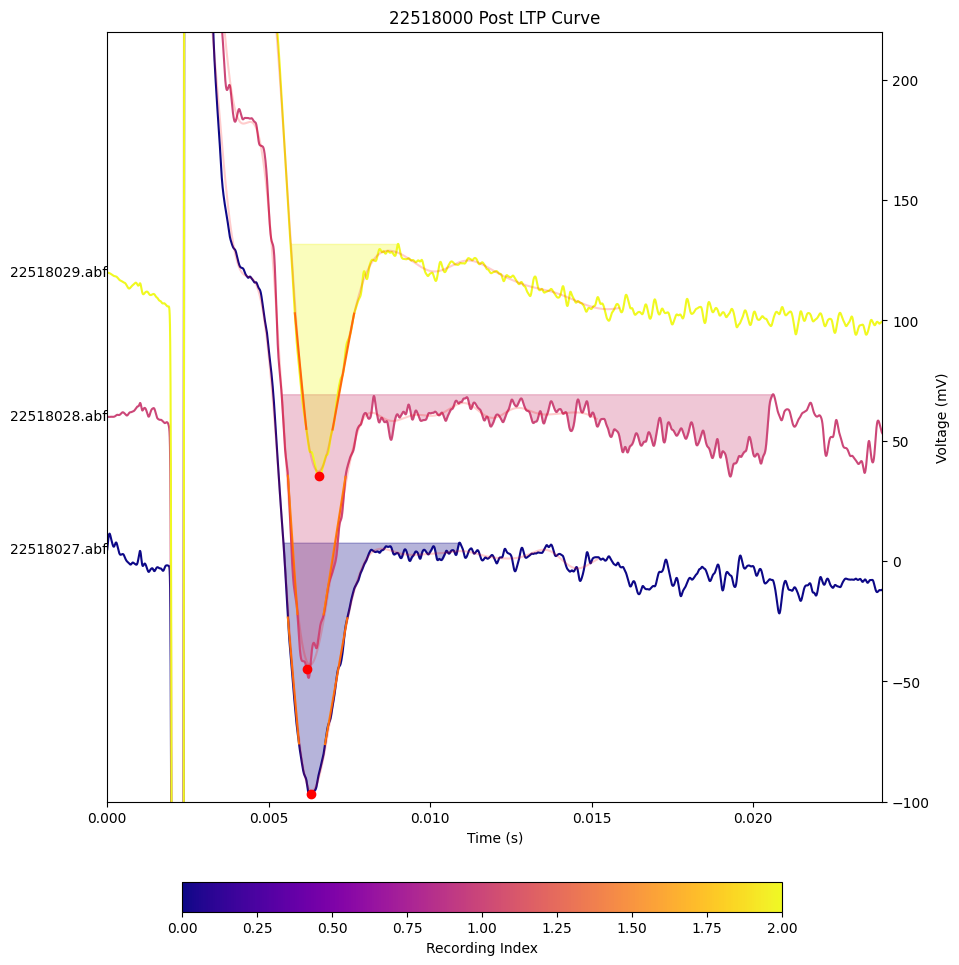

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/2608634758.py:343: UserWarning: Could not find baseline crossings before peak. Using max before peak
  warnings.warn("Could not find baseline crossings before peak. Using max before peak")


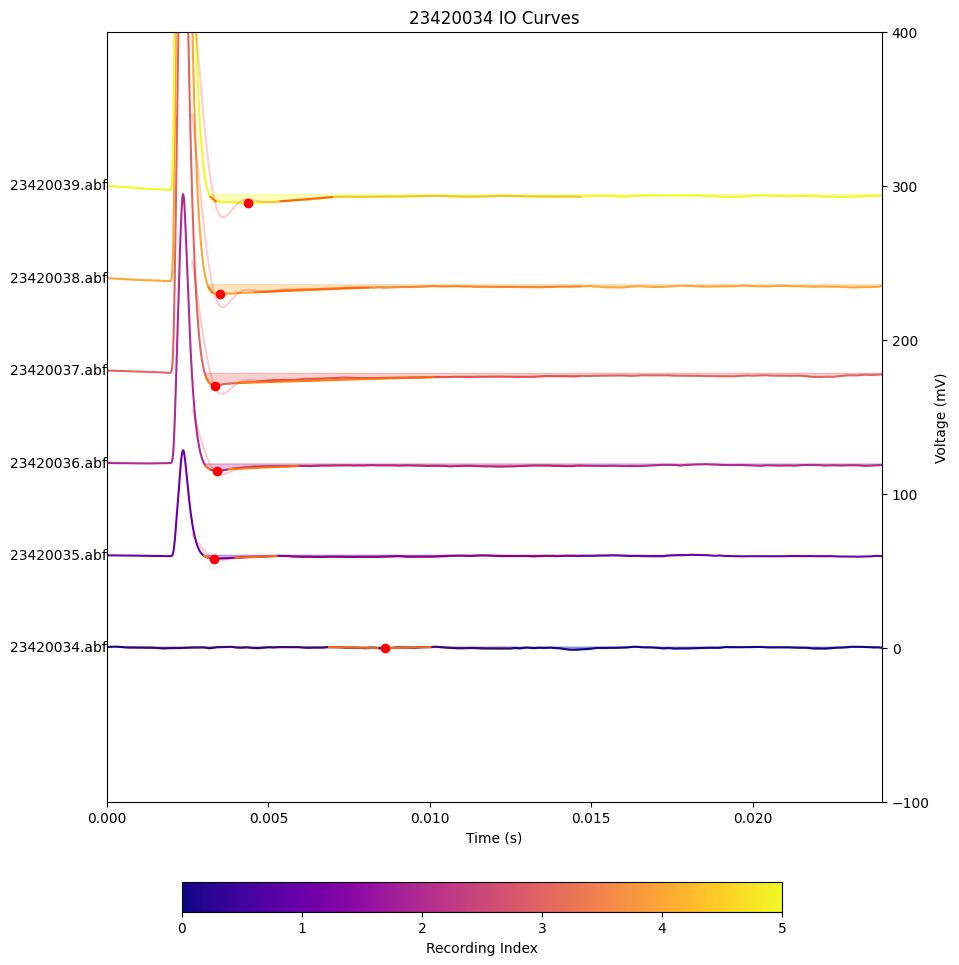

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No BL recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


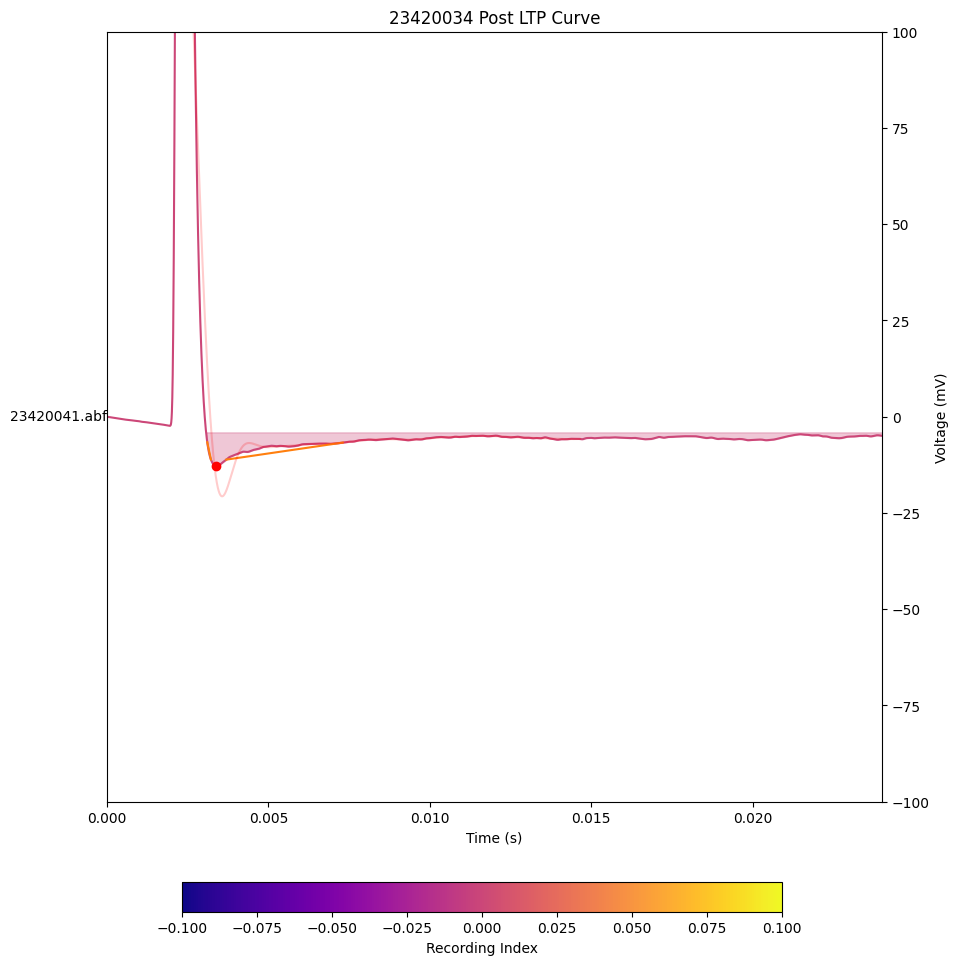

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


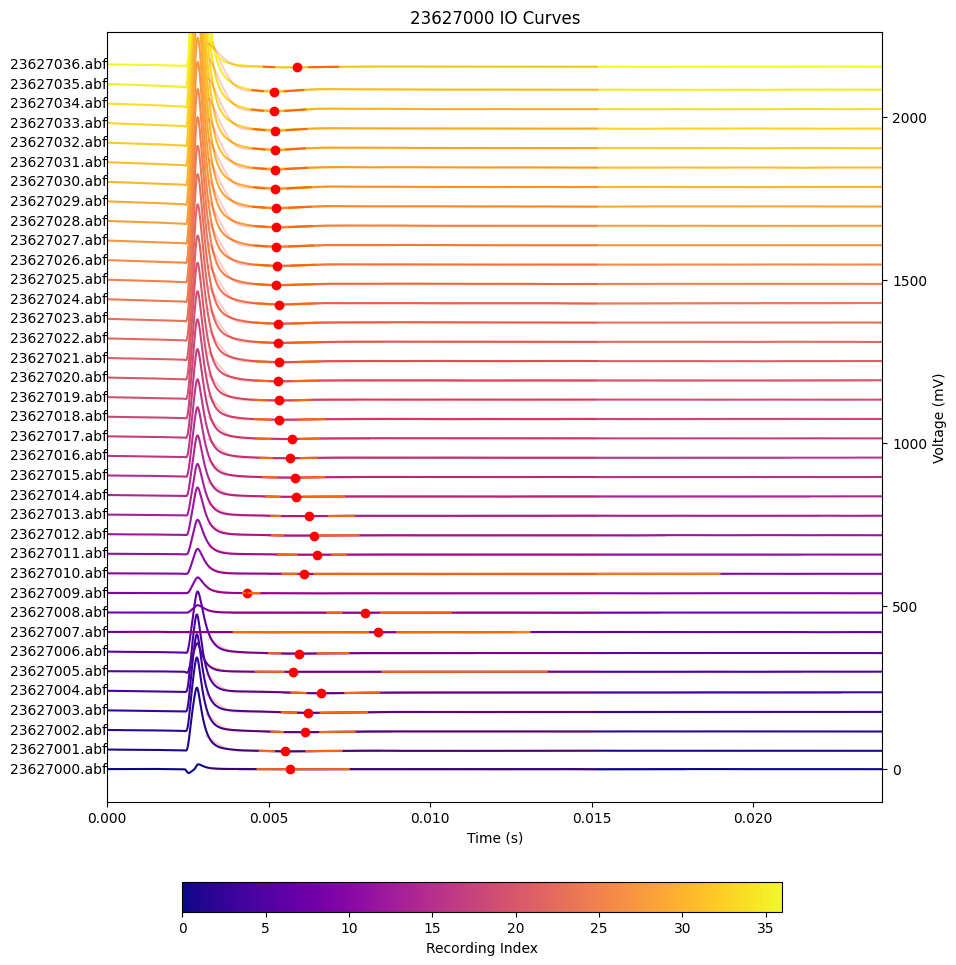

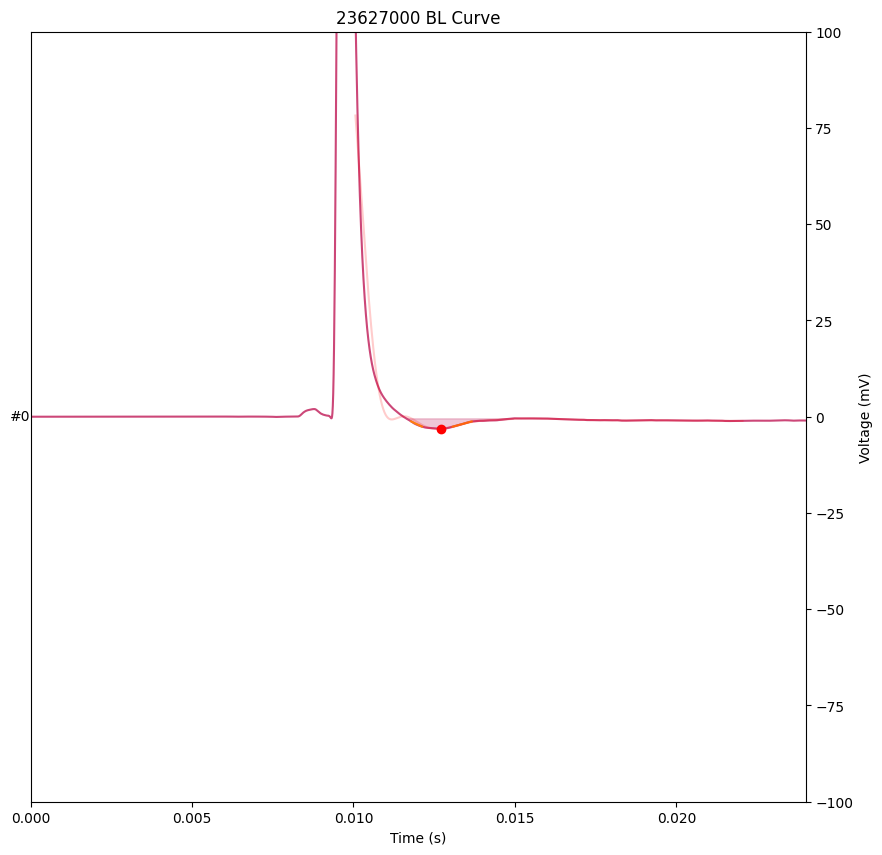

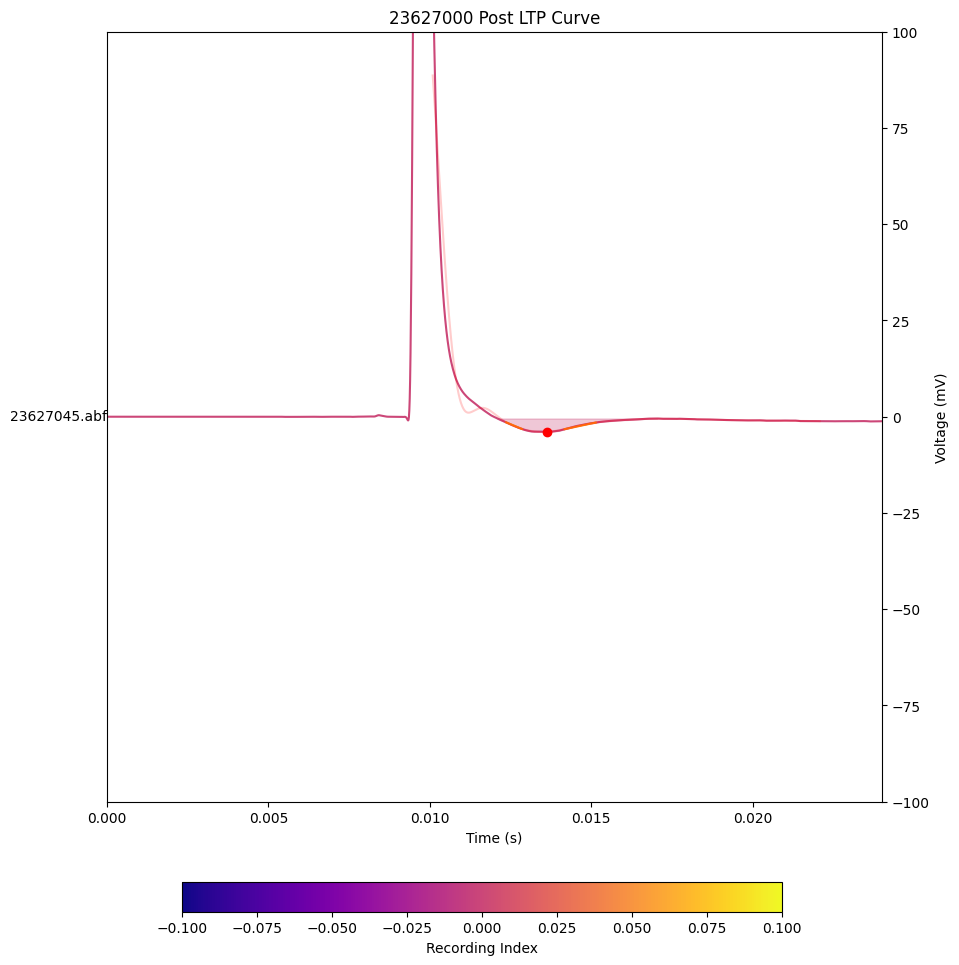

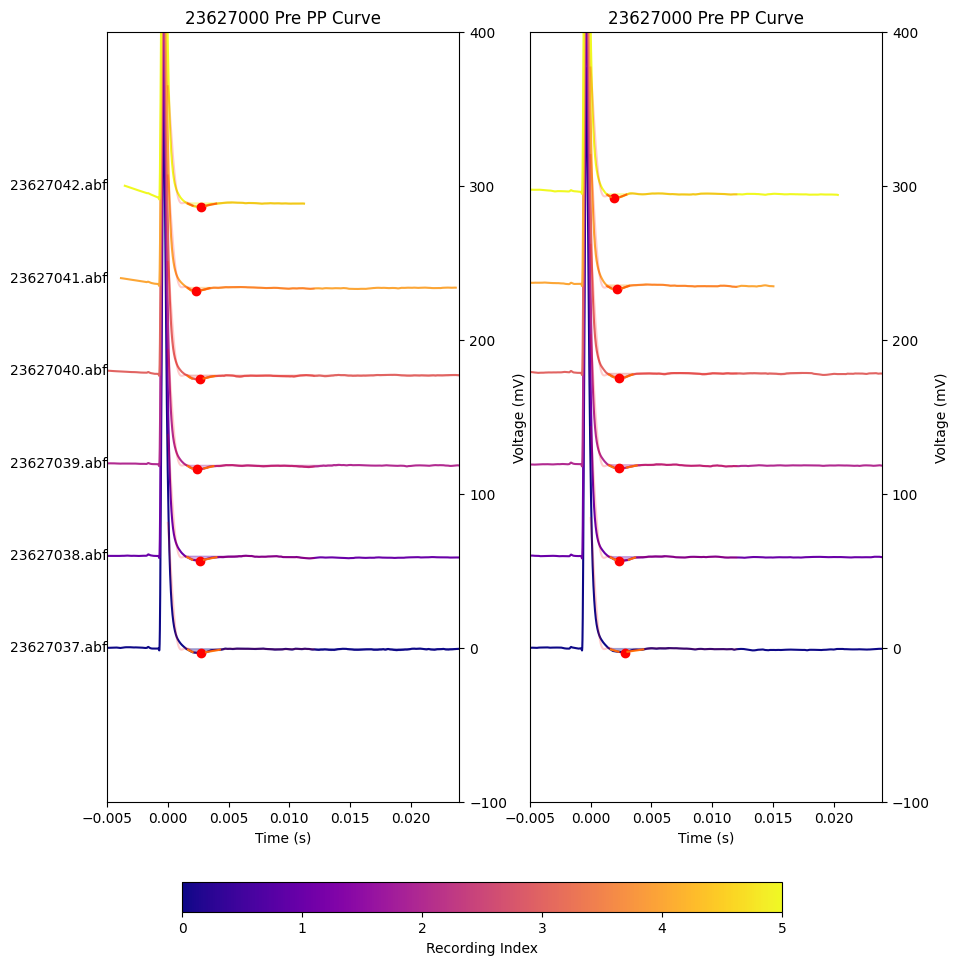

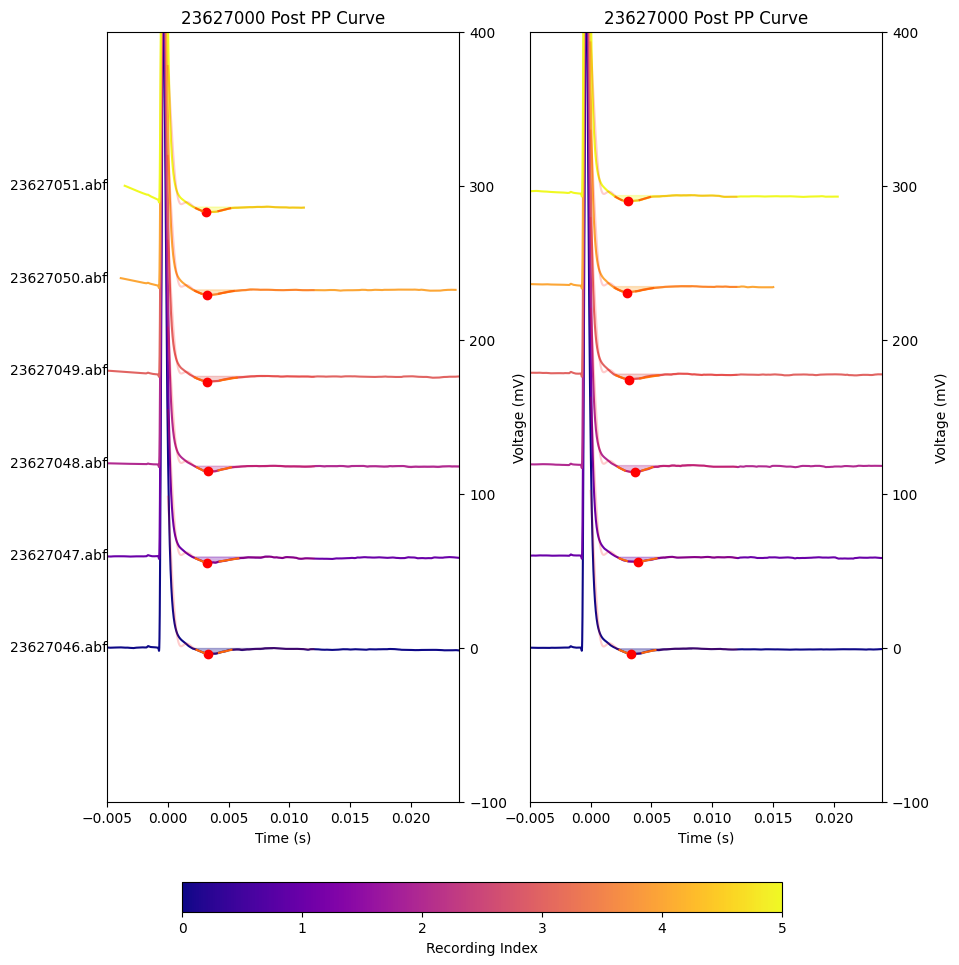

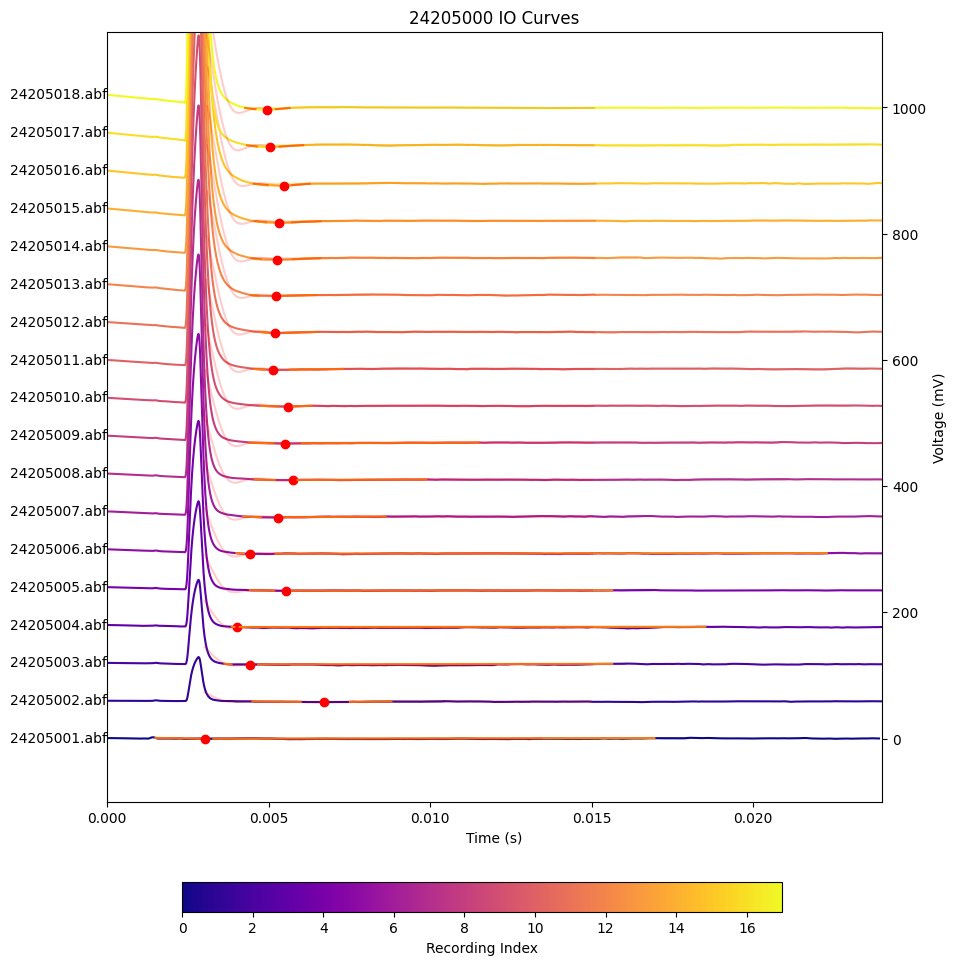

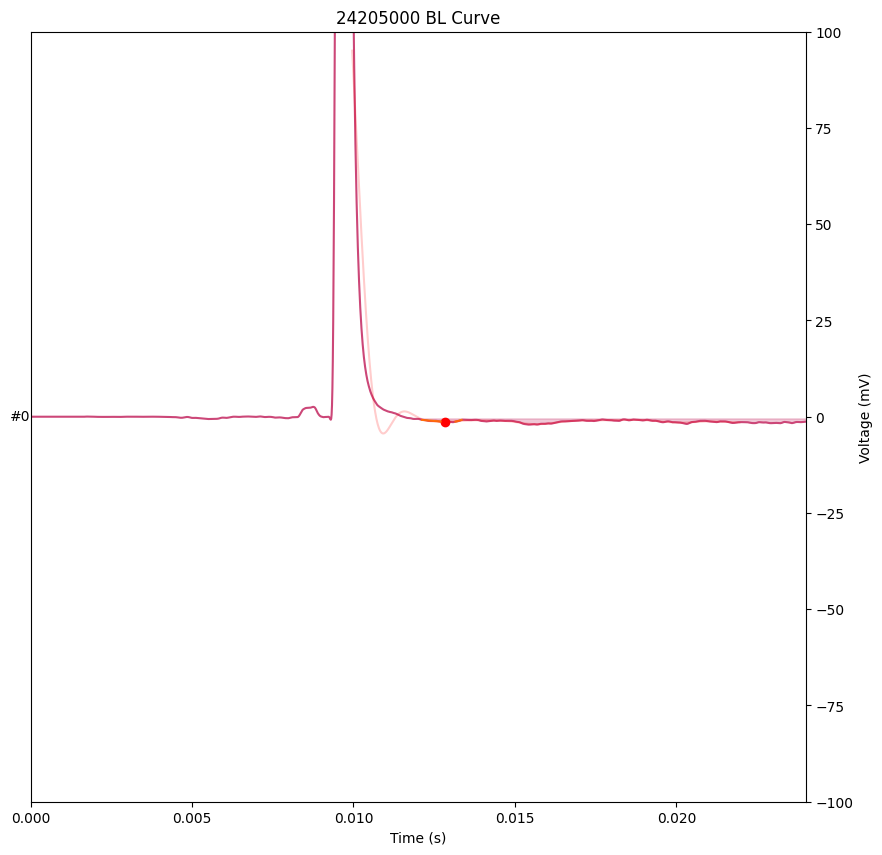

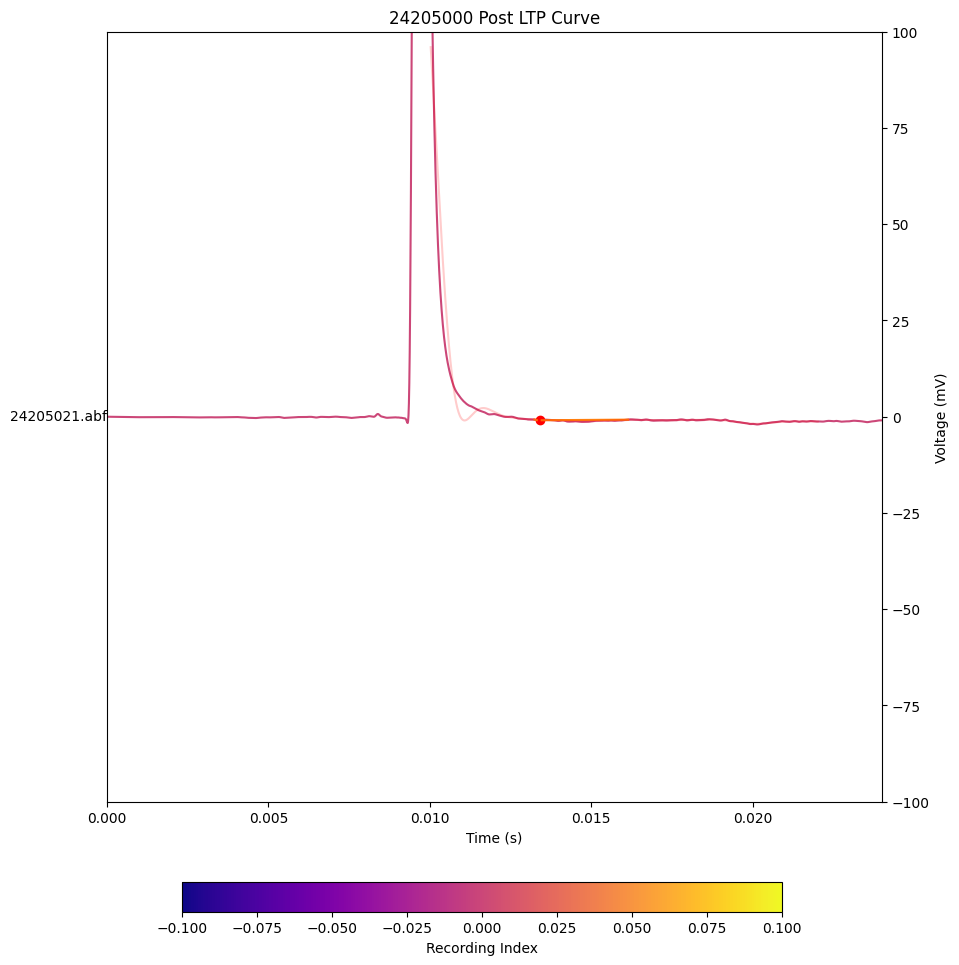

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['24205000-21 4x.jpg', '24205000.abf', 'BL', 'I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['24205000-21 4x.jpg', '24205000.abf', 'BL', 'I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/2608634758.py:343: UserWarning: Could not find baseline crossings before peak. Using max before peak
  warnings.warn("Could not find baseline crossings before peak. Using max before peak")


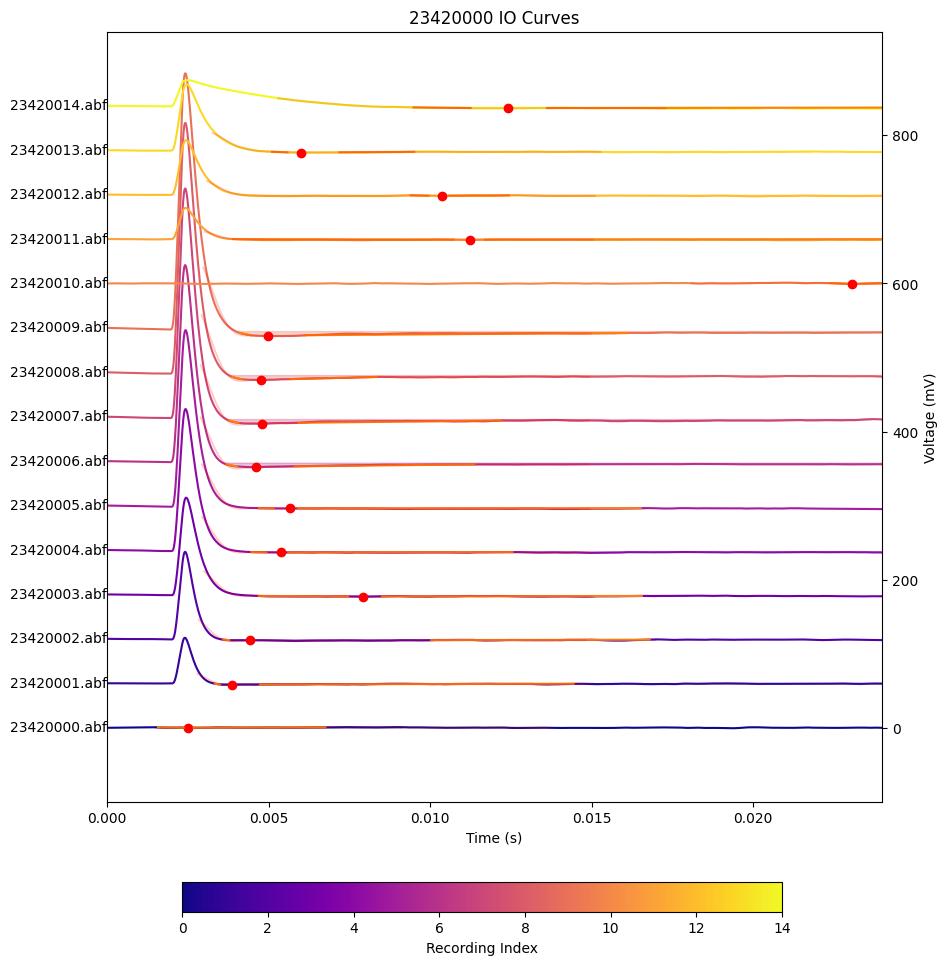

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No BL recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post LTP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


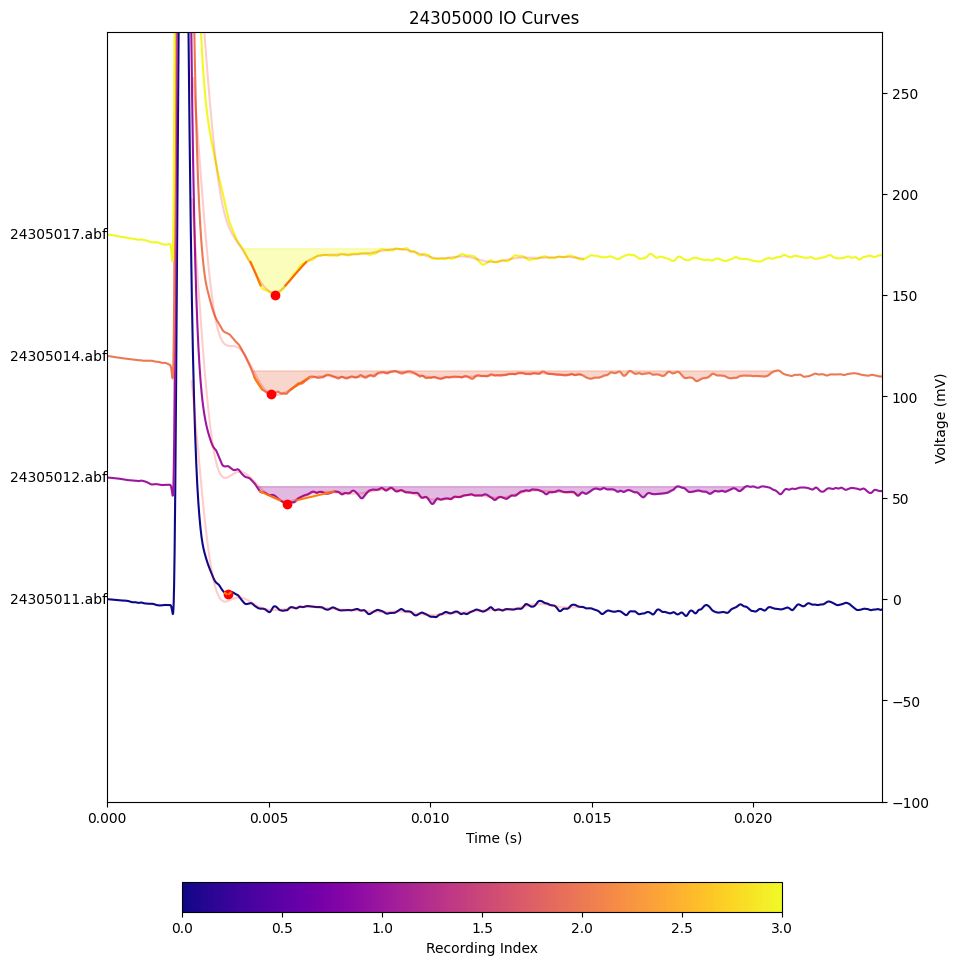

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No BL recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post LTP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/2608634758.py:419: RuntimeWarning: invalid value encountered in scalar divide
  return (self.trace_V[idx2] - self.trace_V[idx1]) / ((idx2 - idx1) / self.f_s)


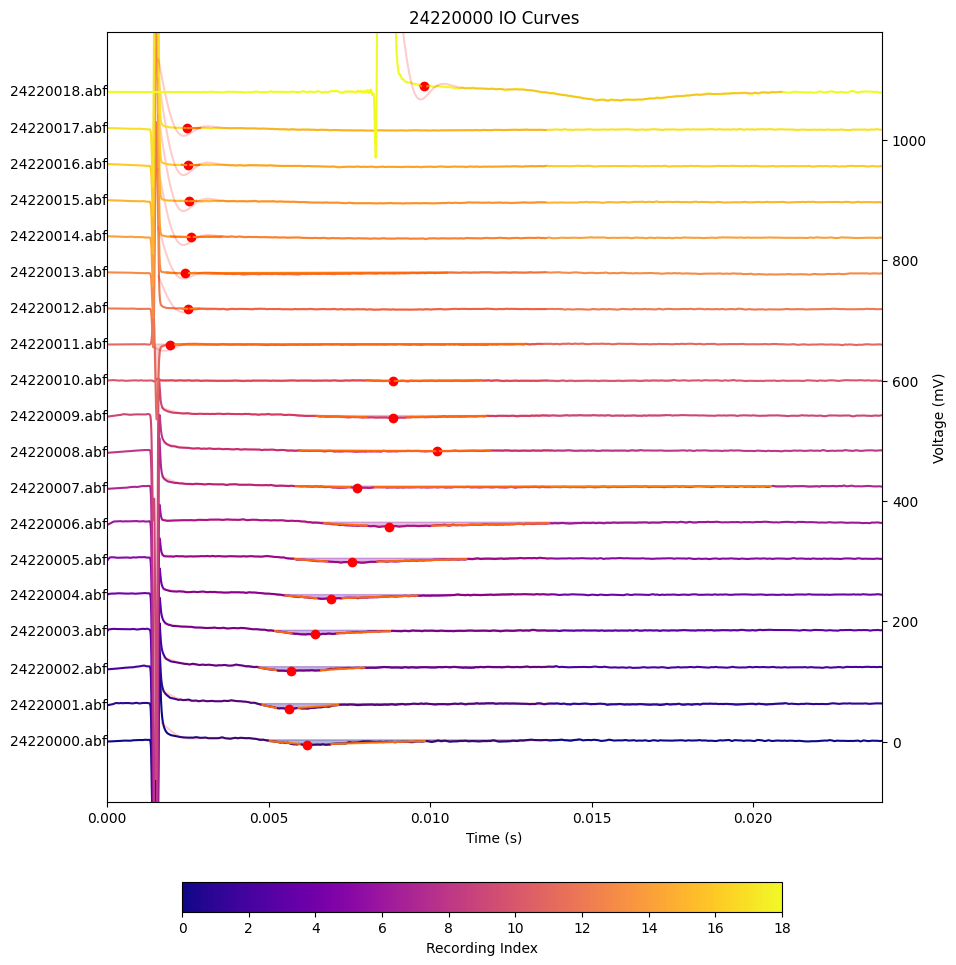

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No BL recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post LTP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


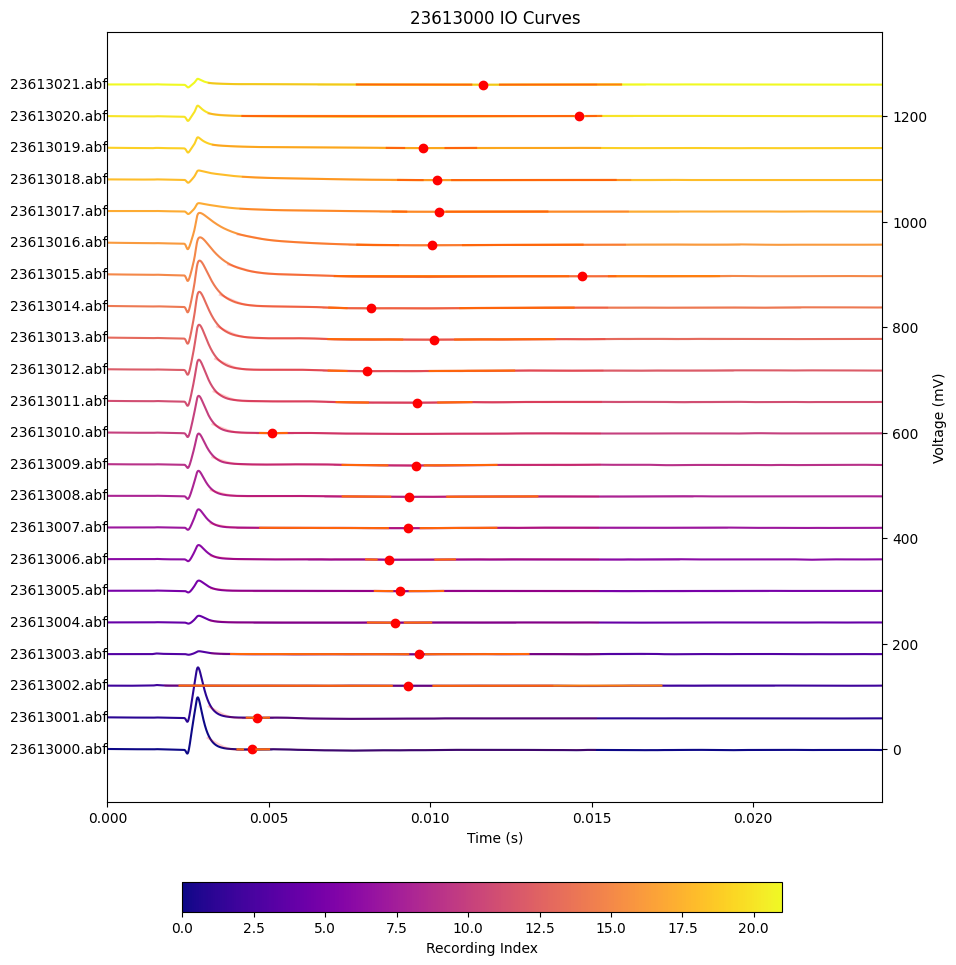

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No BL recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post LTP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['I-O']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


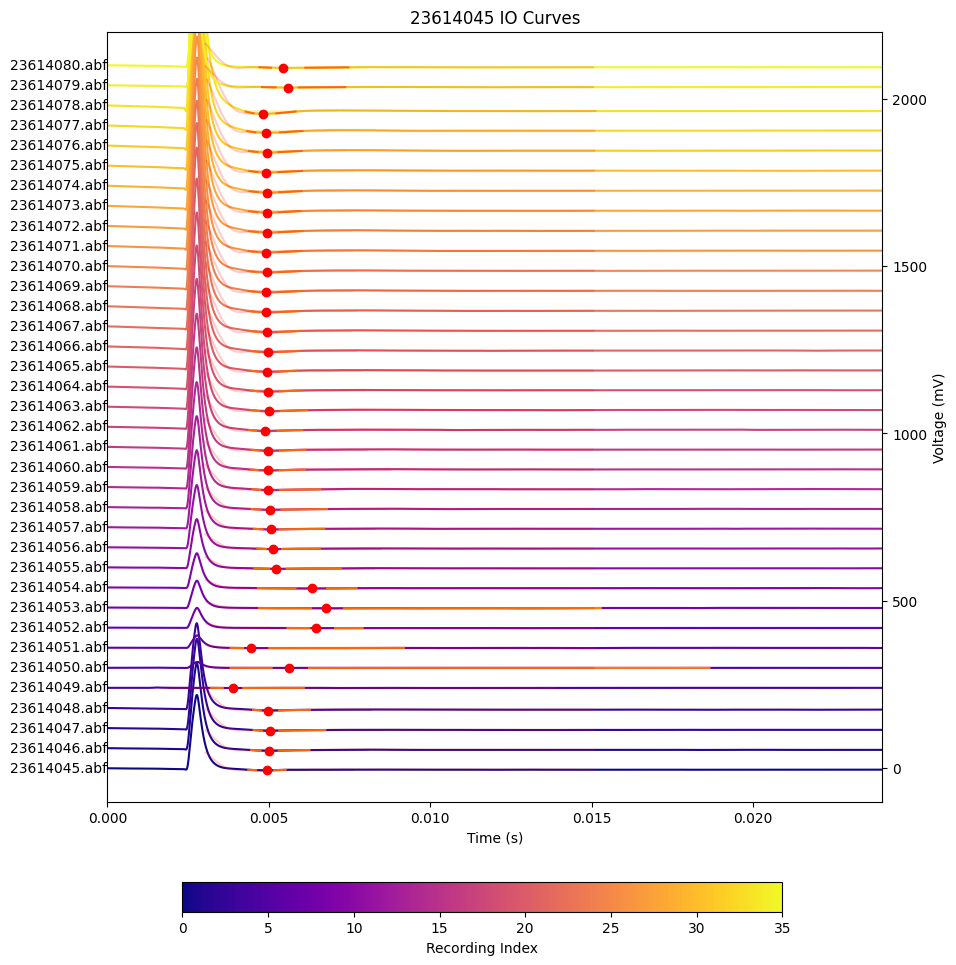

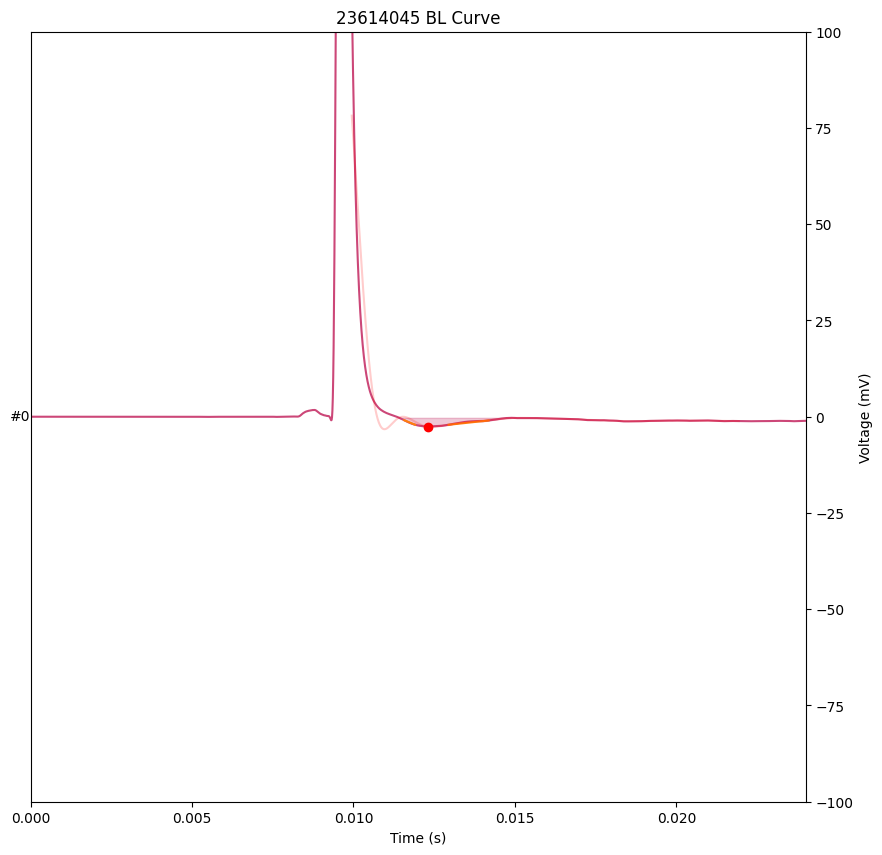

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post LTP recordings found in ['BL', 'I-O', 'LTP', 'Post PP', 'Pre PP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


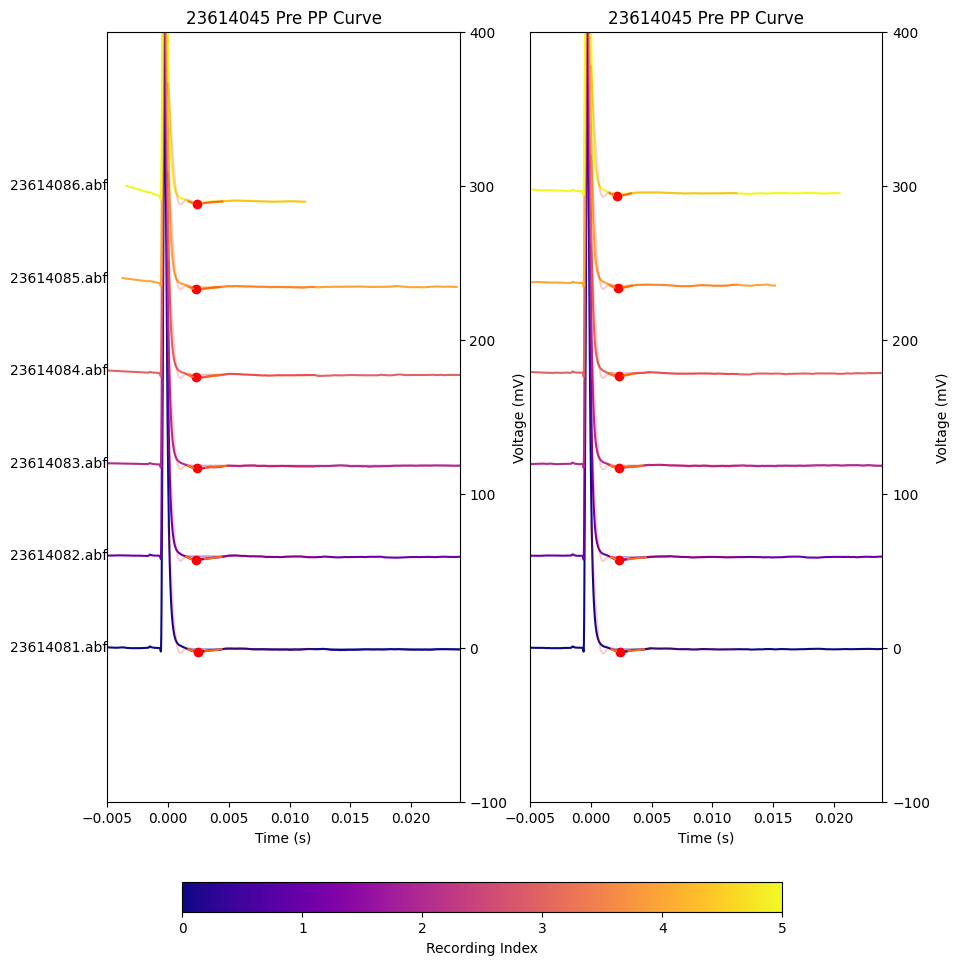

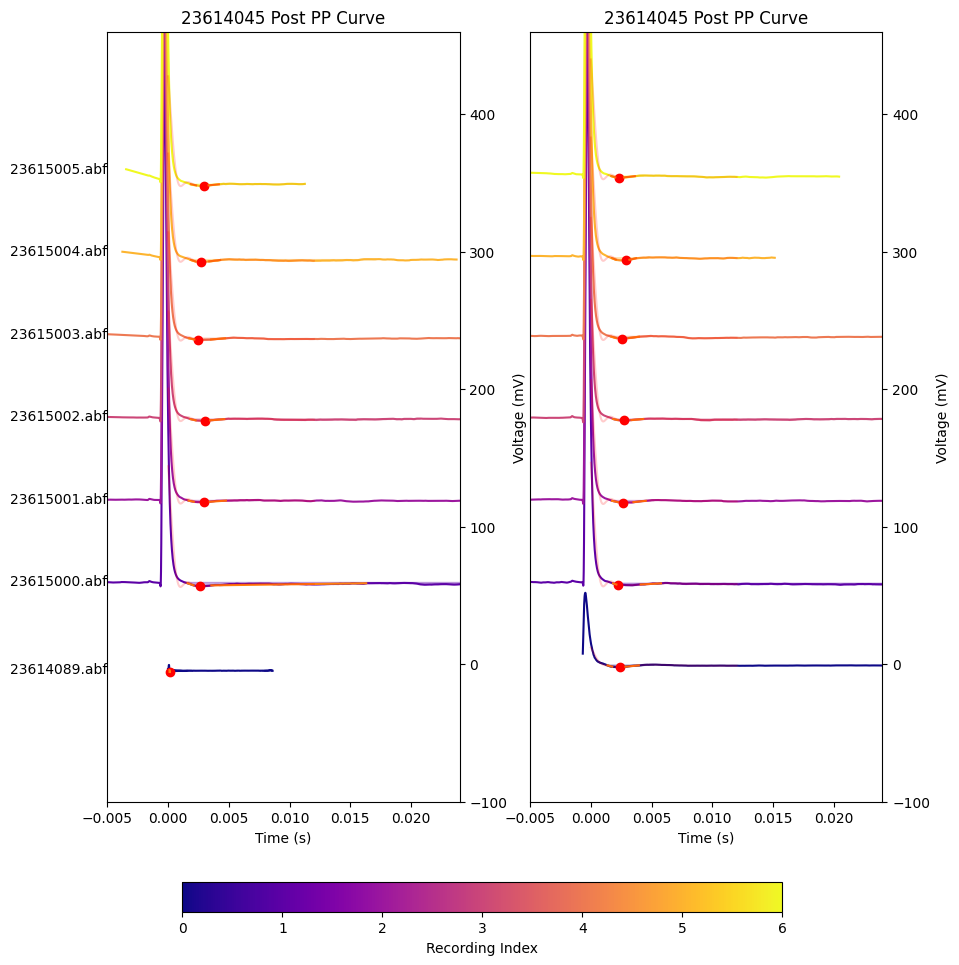

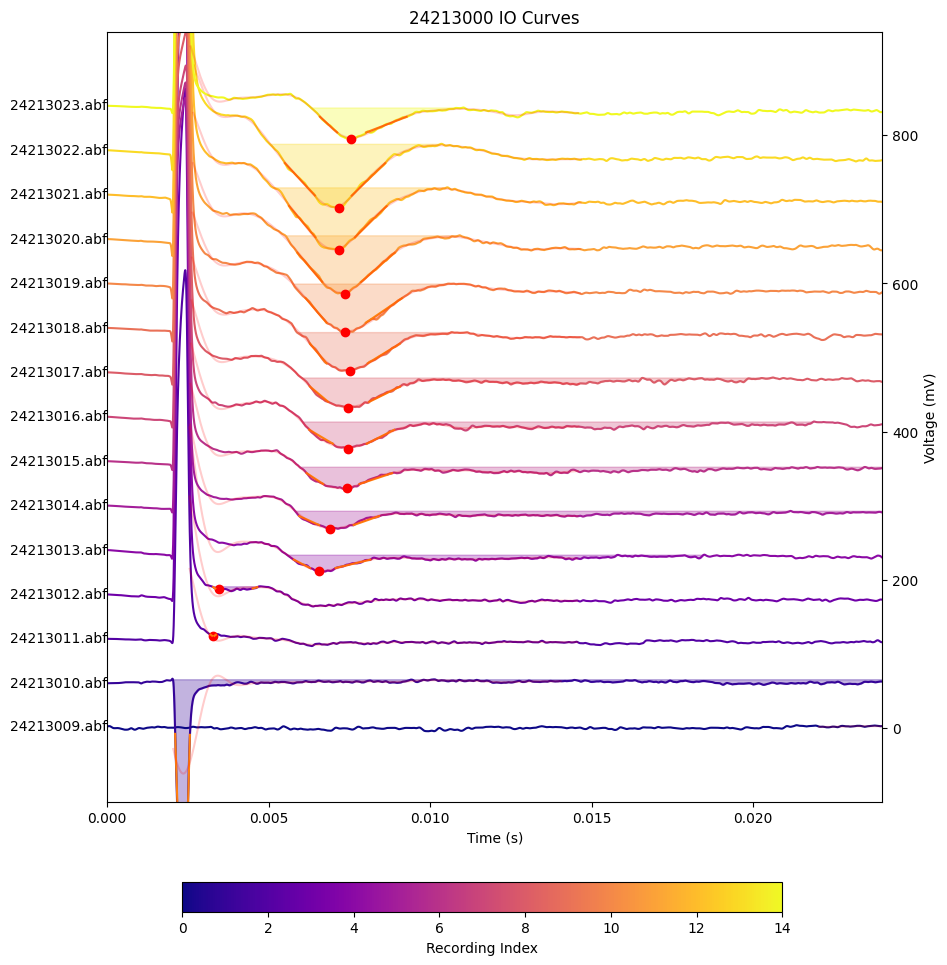

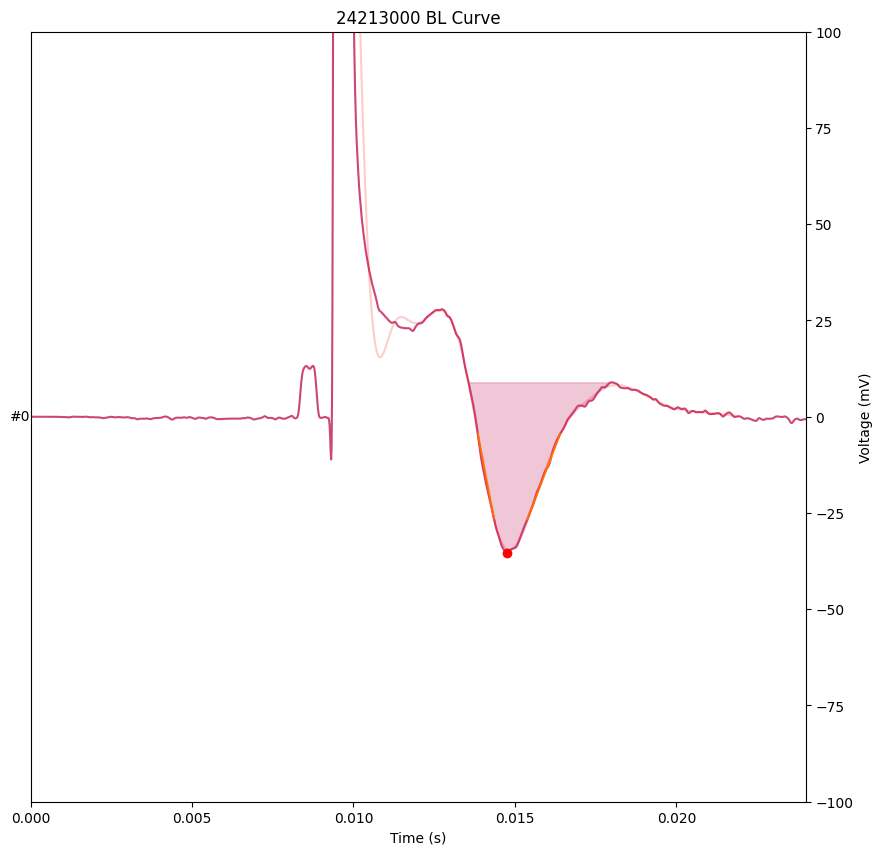

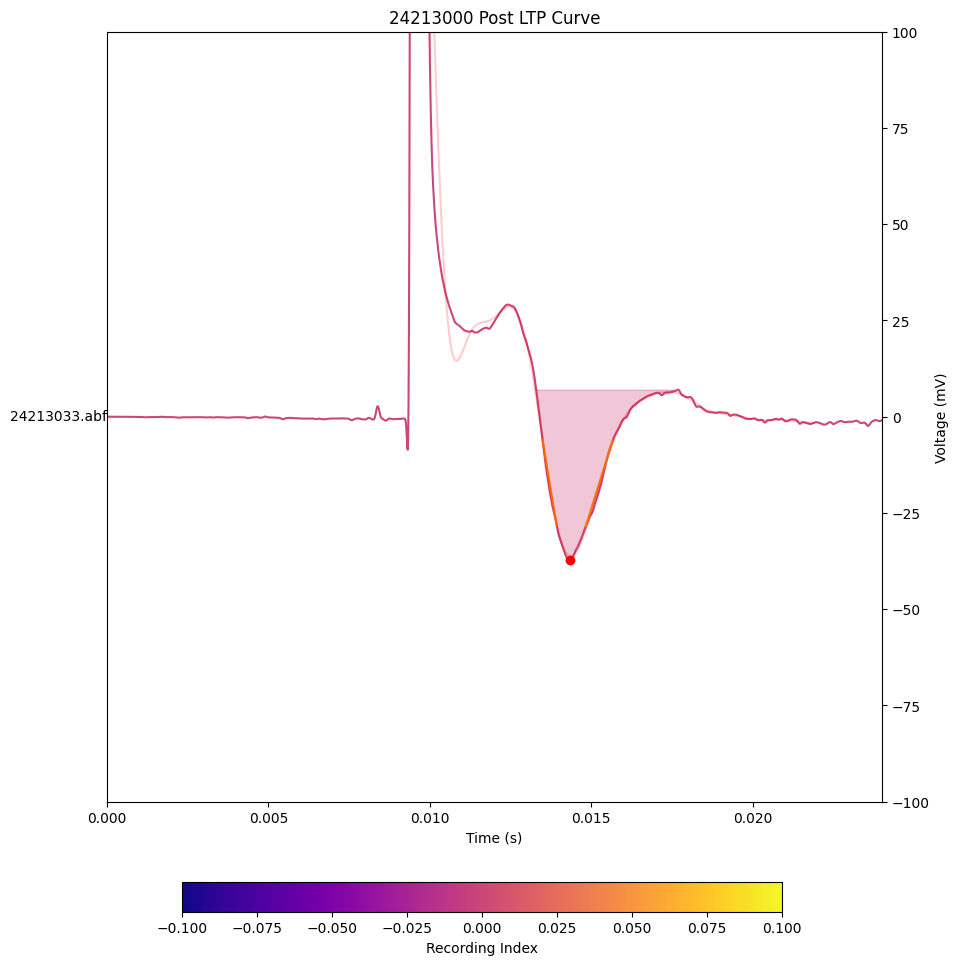

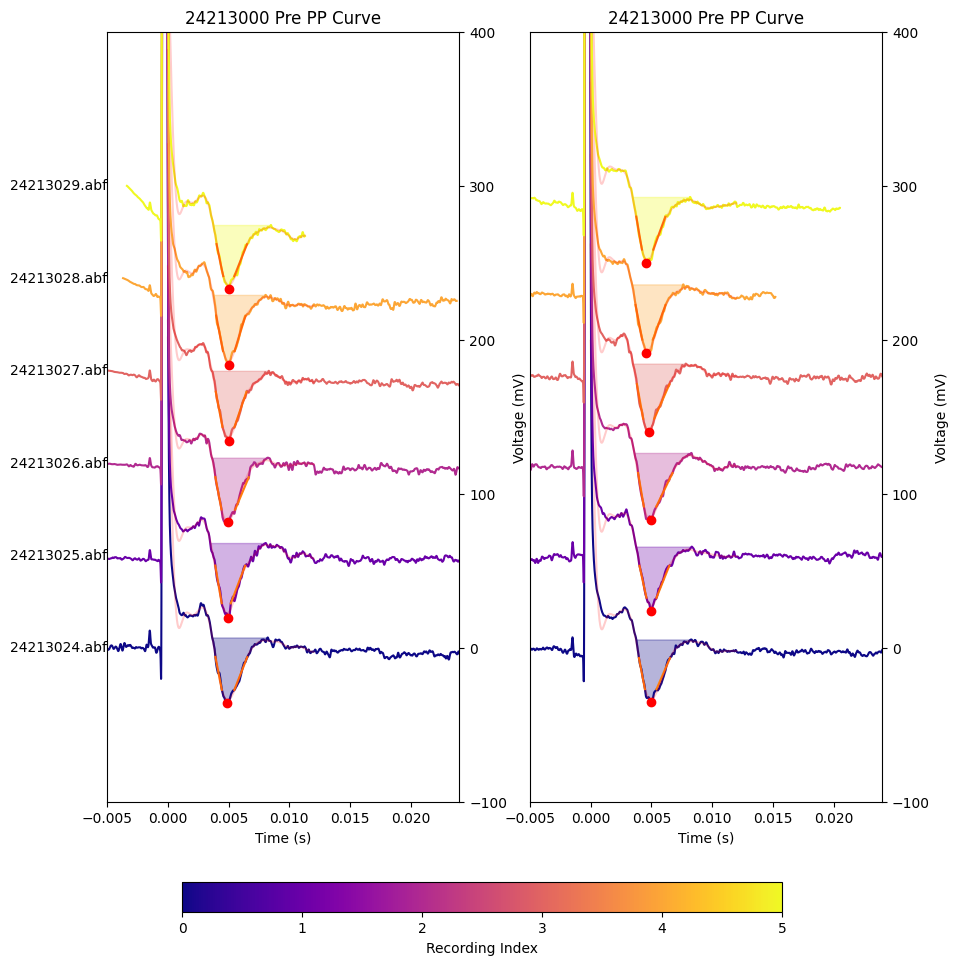

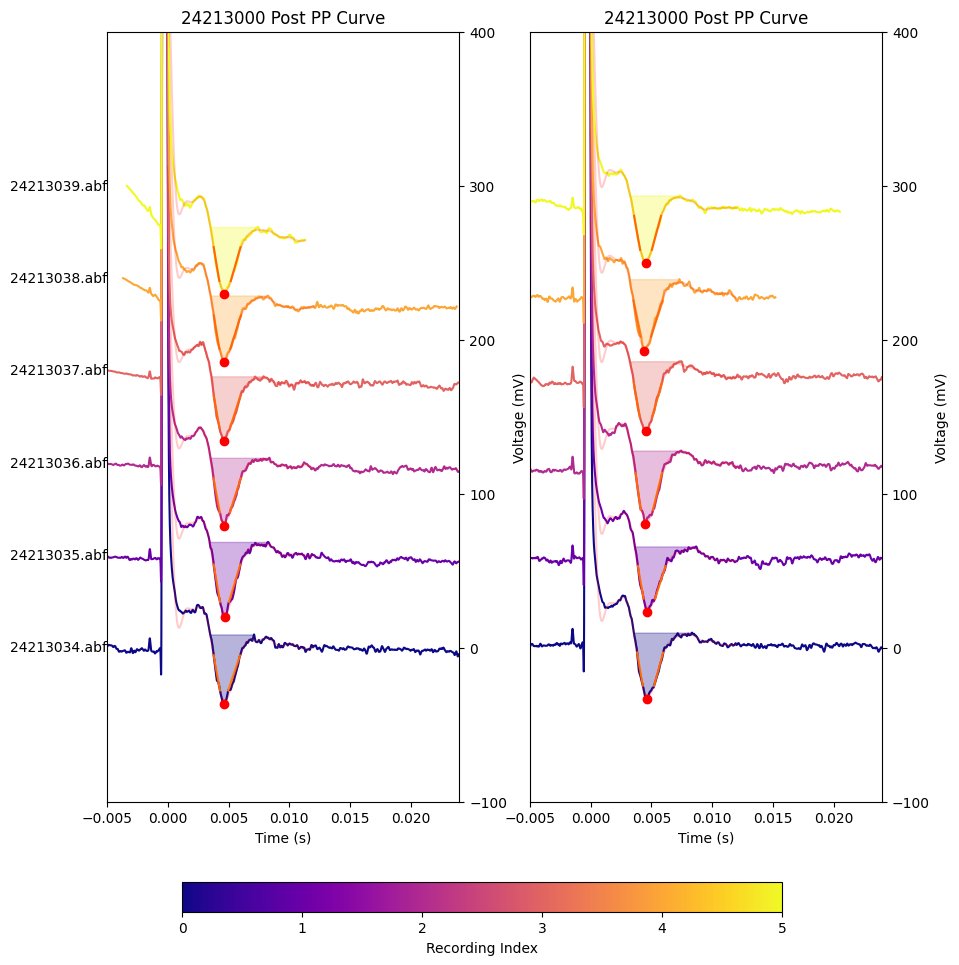

Error loading ABF (buffer error): unpack requires a buffer of 1 bytes
Error loading ABF (buffer error): unpack requires a buffer of 1 bytes


/tmp/ipykernel_2353744/2608634758.py:12: UserWarning: trace_V is None. Skipping negation.
  warnings.warn("trace_V is None. Skipping negation.")
/tmp/ipykernel_2353744/1325616311.py:23: UserWarning: V, t, and f_s are None. Skipping trace.
  warnings.warn("V, t, and f_s are None. Skipping trace.")
/tmp/ipykernel_2353744/2608634758.py:12: UserWarning: trace_V is None. Skipping negation.
  warnings.warn("trace_V is None. Skipping negation.")
/tmp/ipykernel_2353744/1325616311.py:23: UserWarning: V, t, and f_s are None. Skipping trace.
  warnings.warn("V, t, and f_s are None. Skipping trace.")
/tmp/ipykernel_2353744/2608634758.py:343: UserWarning: Could not find baseline crossings before peak. Using max before peak
  warnings.warn("Could not find baseline crossings before peak. Using max before peak")


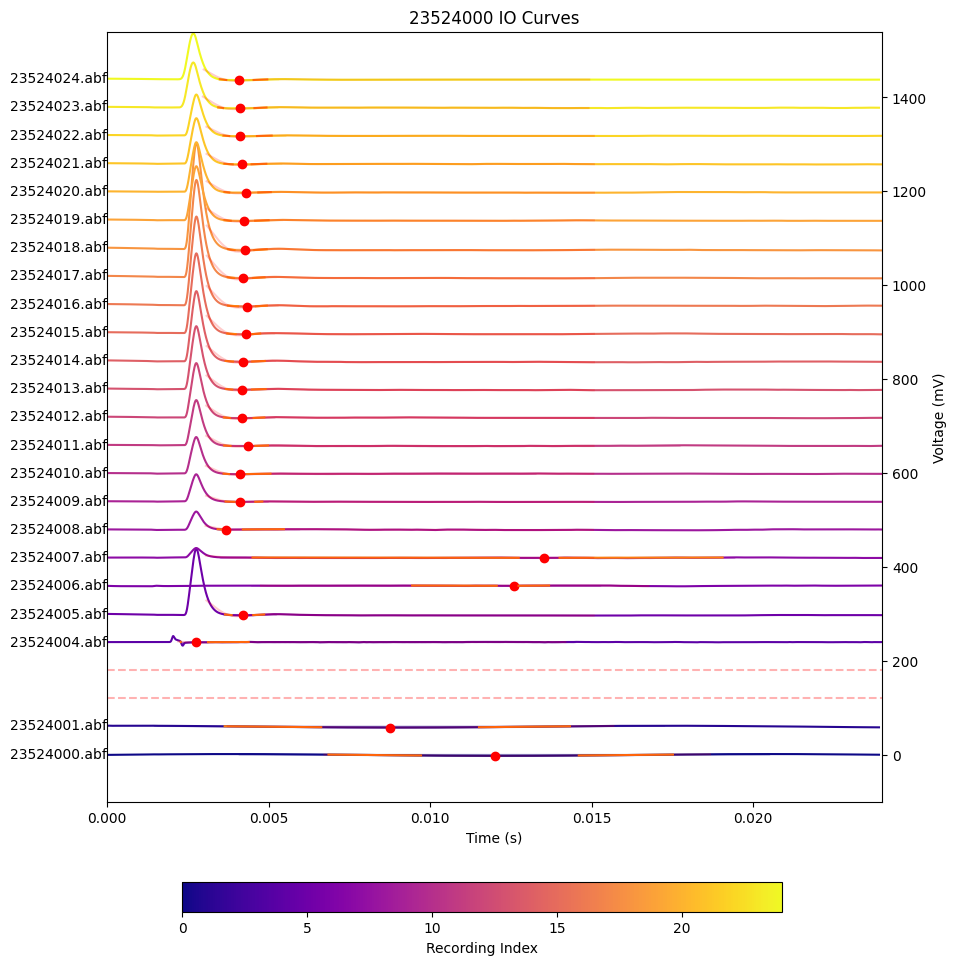

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No BL recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


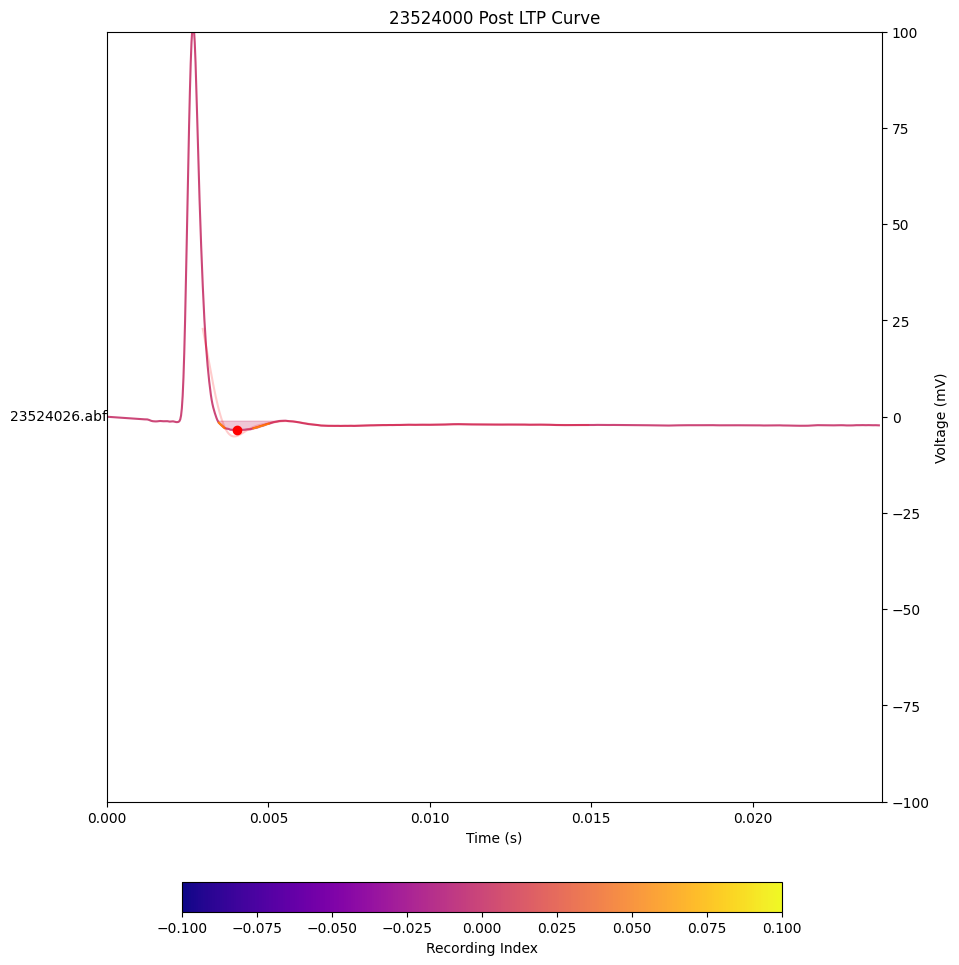

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/2608634758.py:343: UserWarning: Could not find baseline crossings before peak. Using max before peak
  warnings.warn("Could not find baseline crossings before peak. Using max before peak")


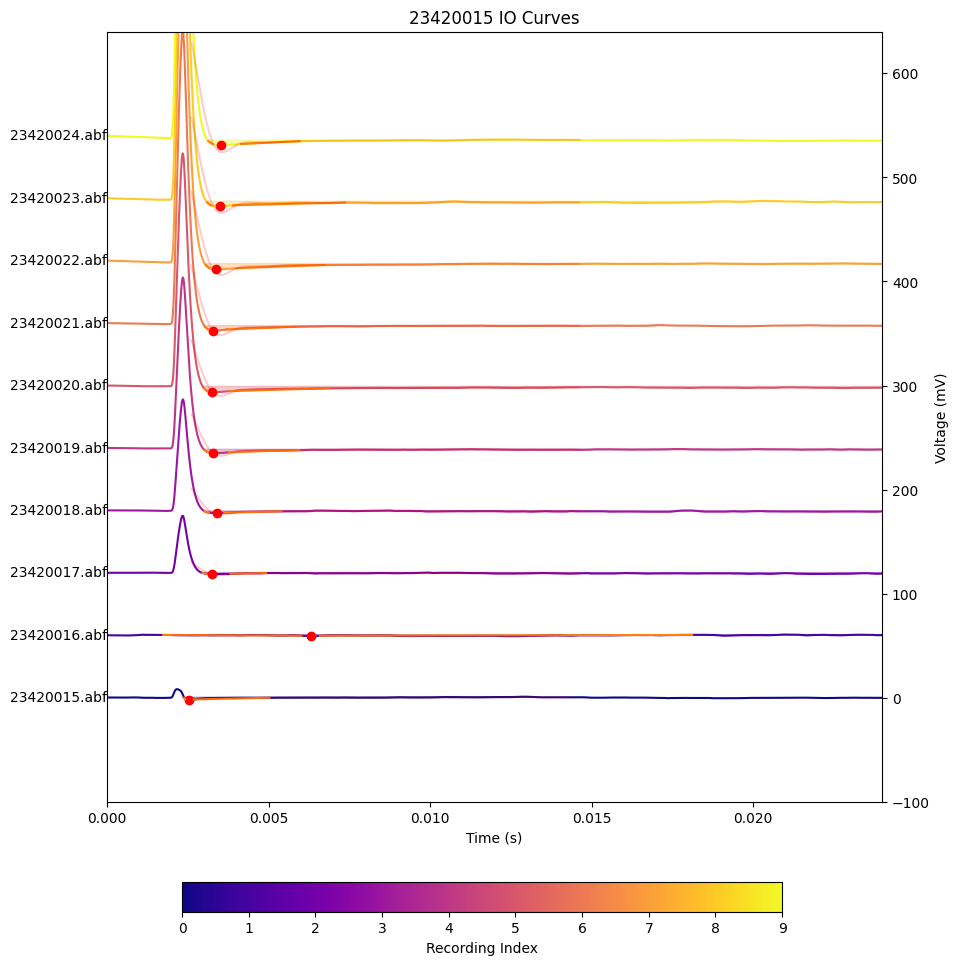

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No BL recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


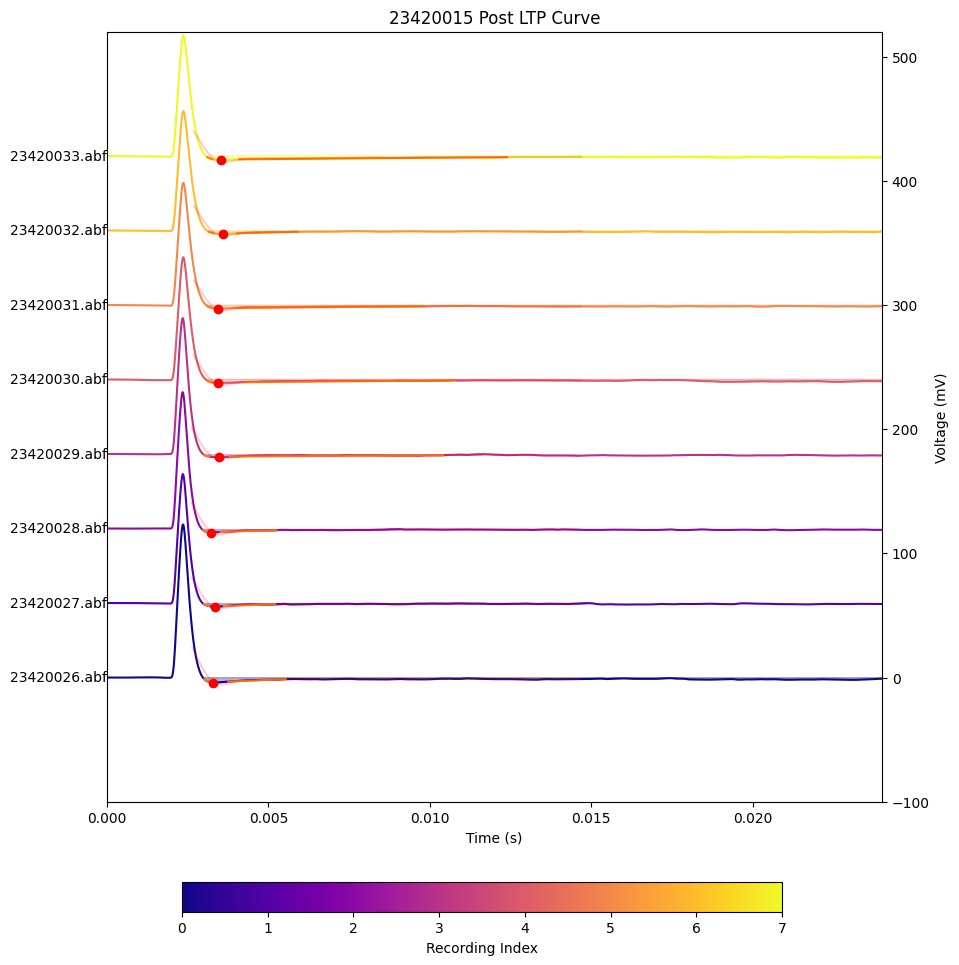

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/2608634758.py:343: UserWarning: Could not find baseline crossings before peak. Using max before peak
  warnings.warn("Could not find baseline crossings before peak. Using max before peak")


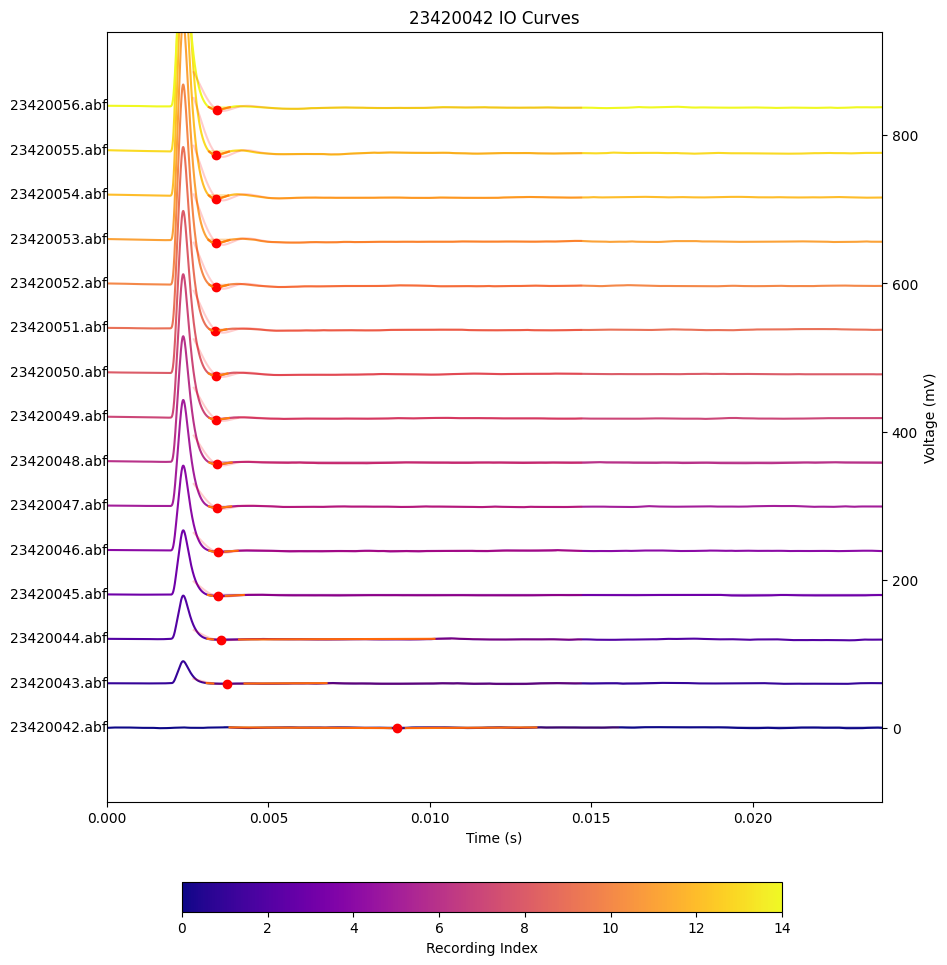

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No BL recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


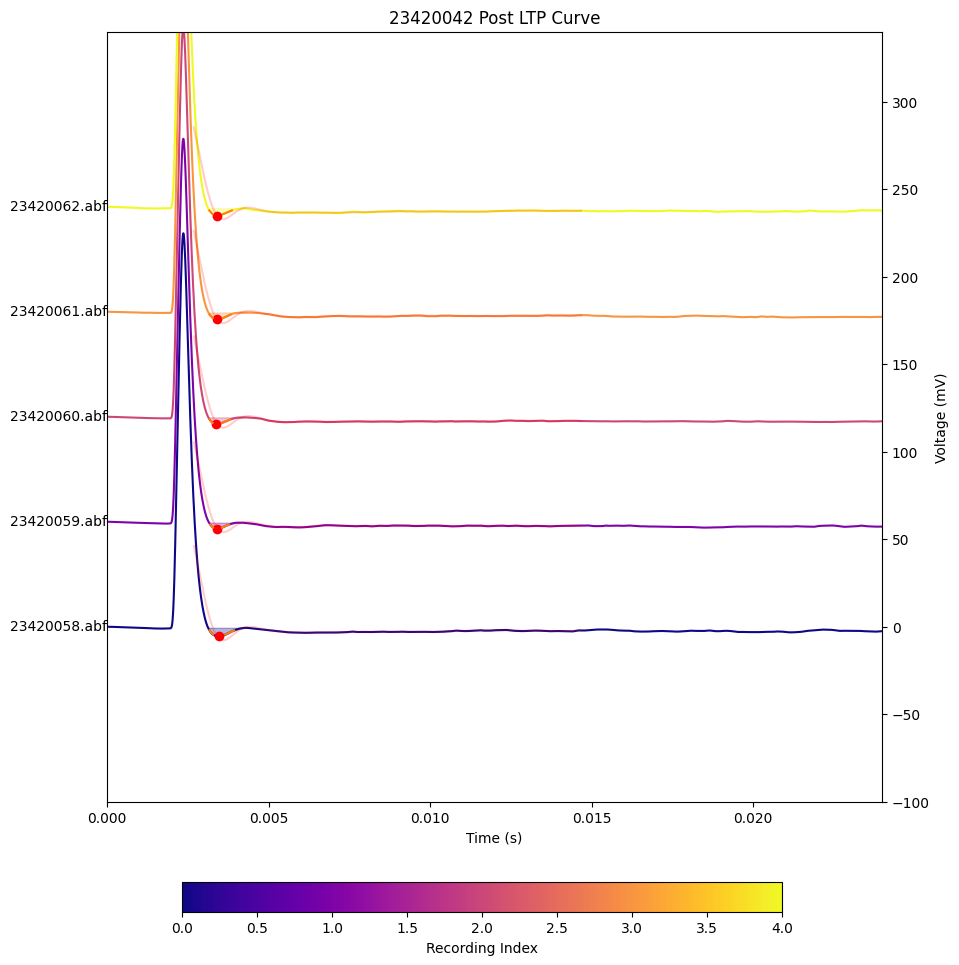

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


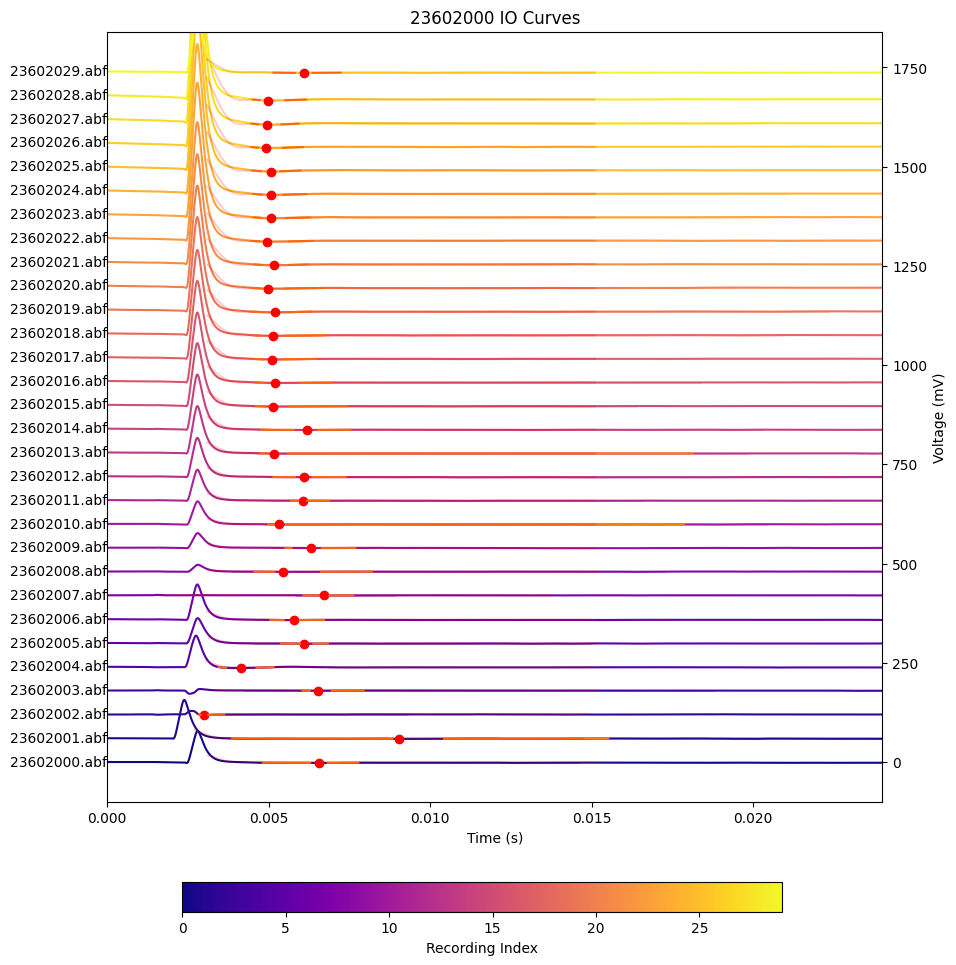

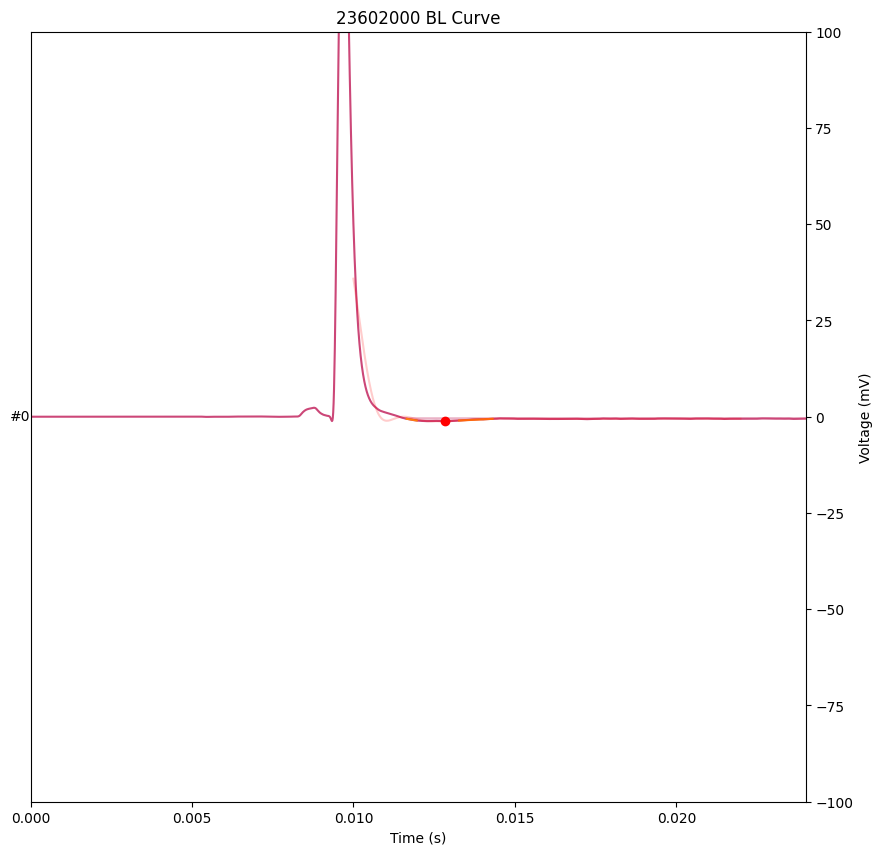

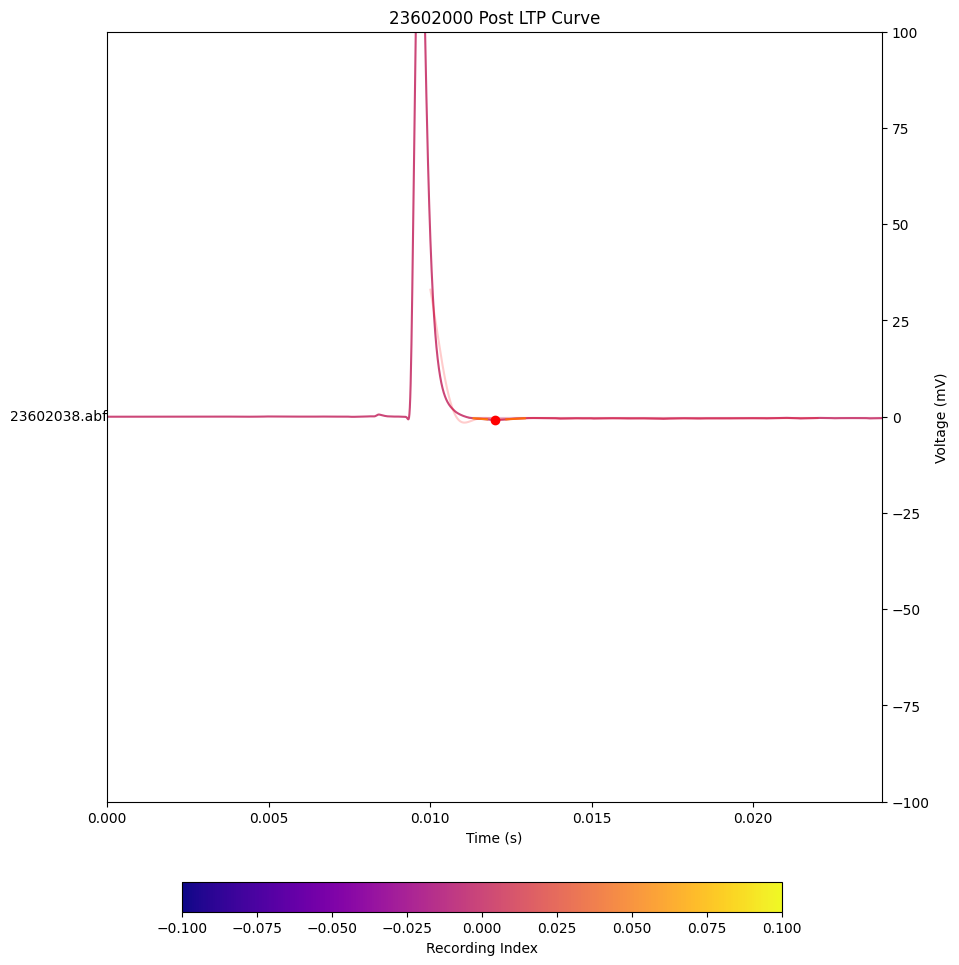

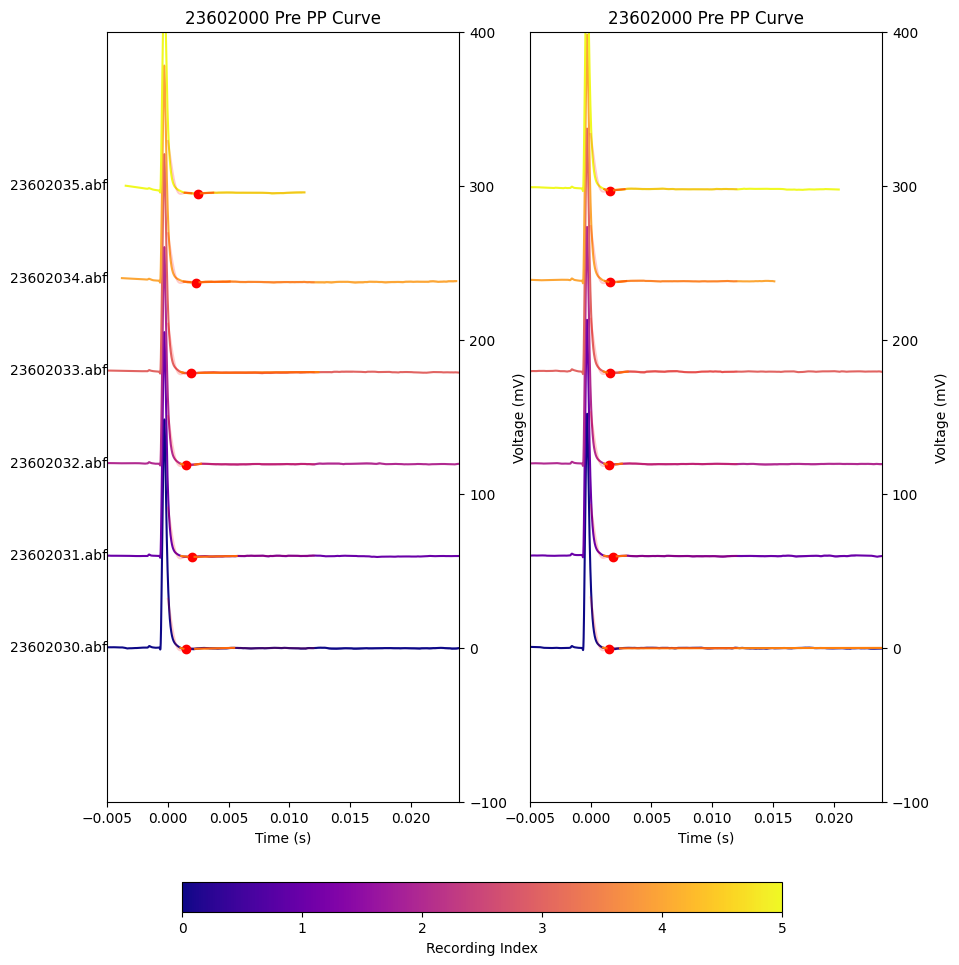

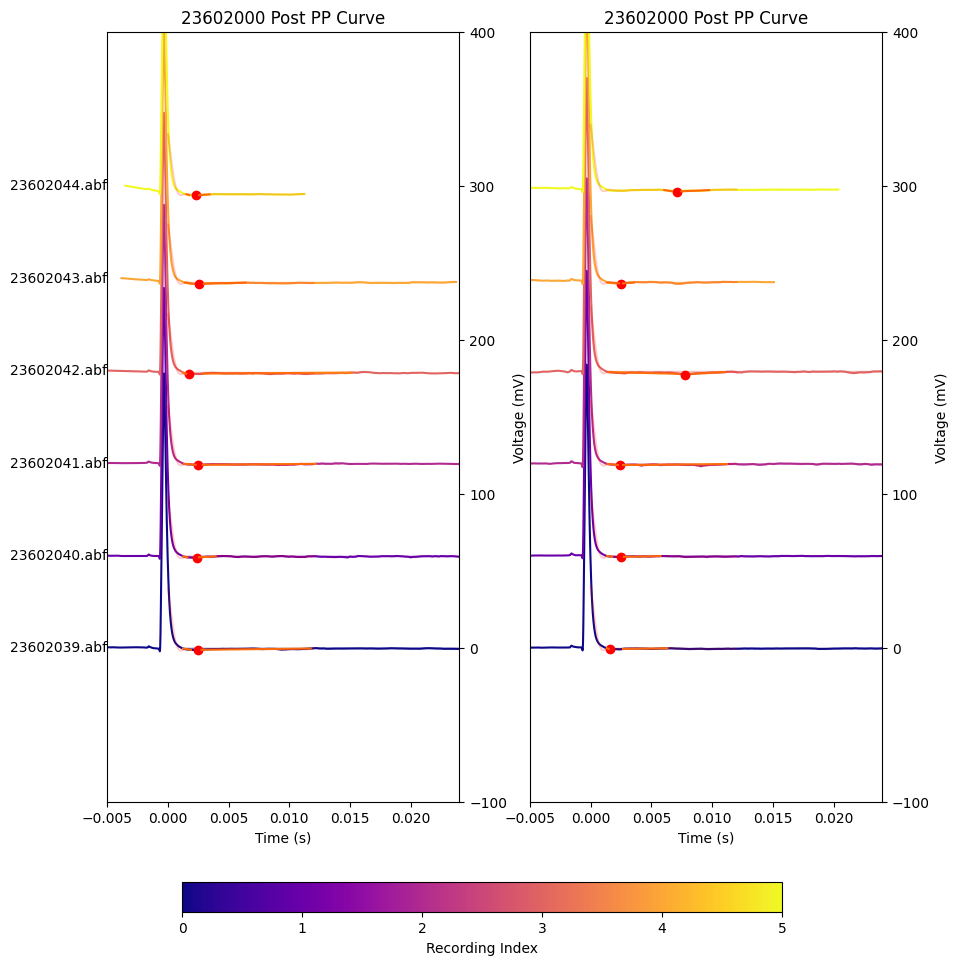

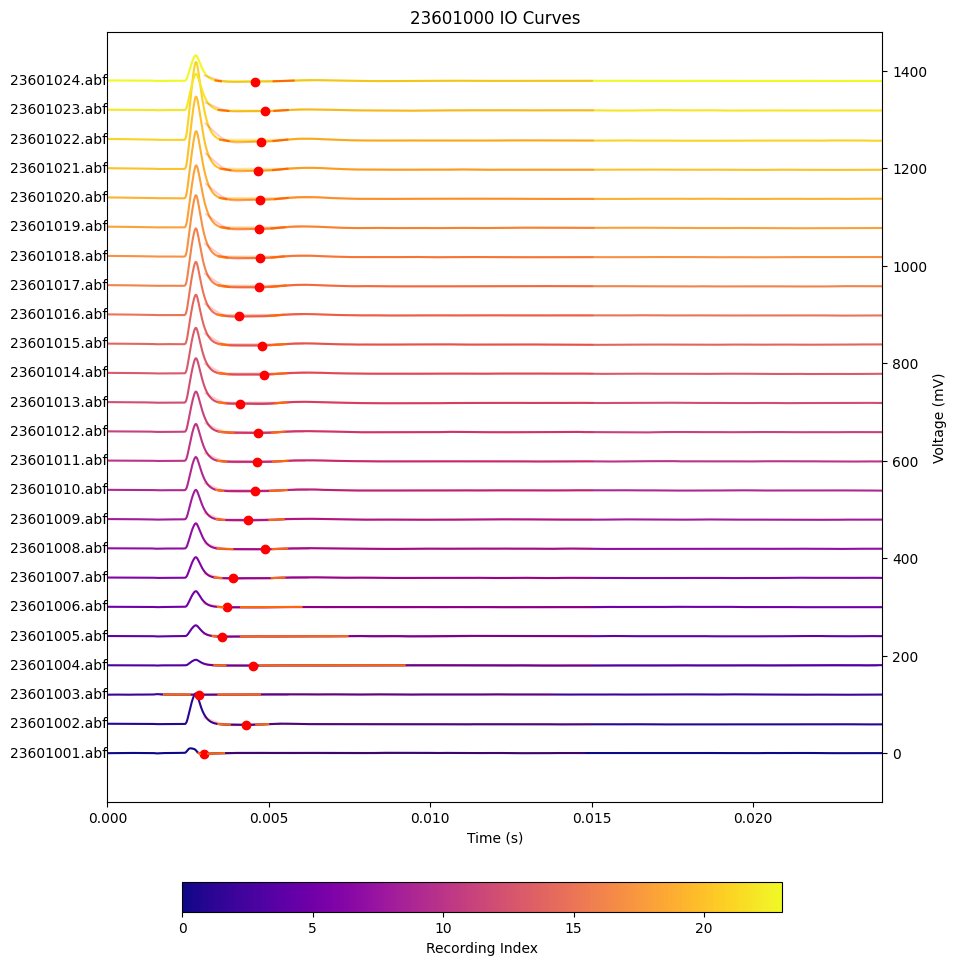

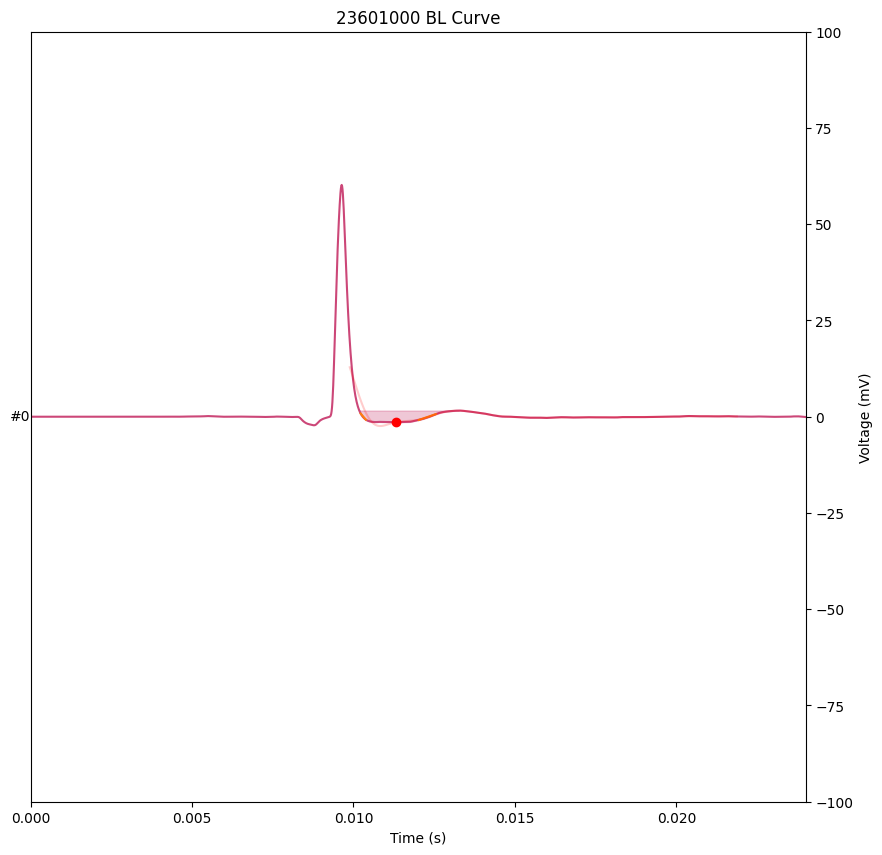

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post LTP recordings found in ['BL', 'I-O', 'LTP', 'Post PP', 'Pre PP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


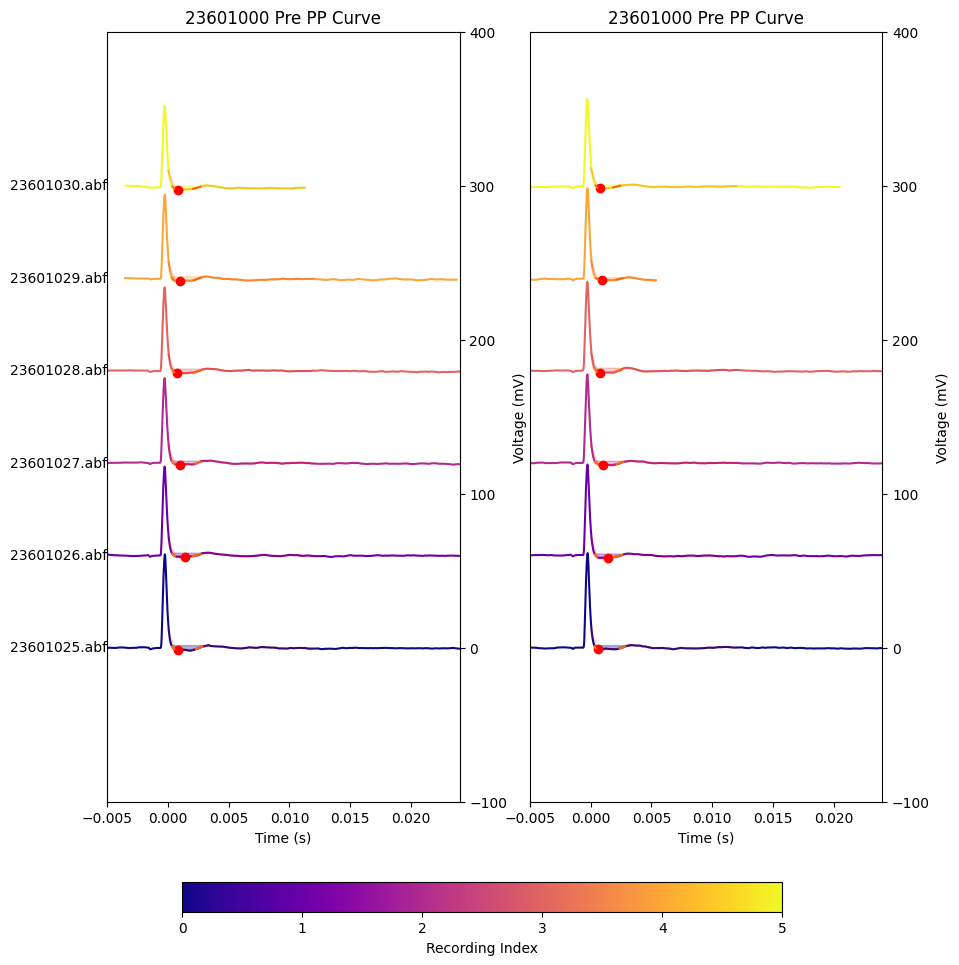

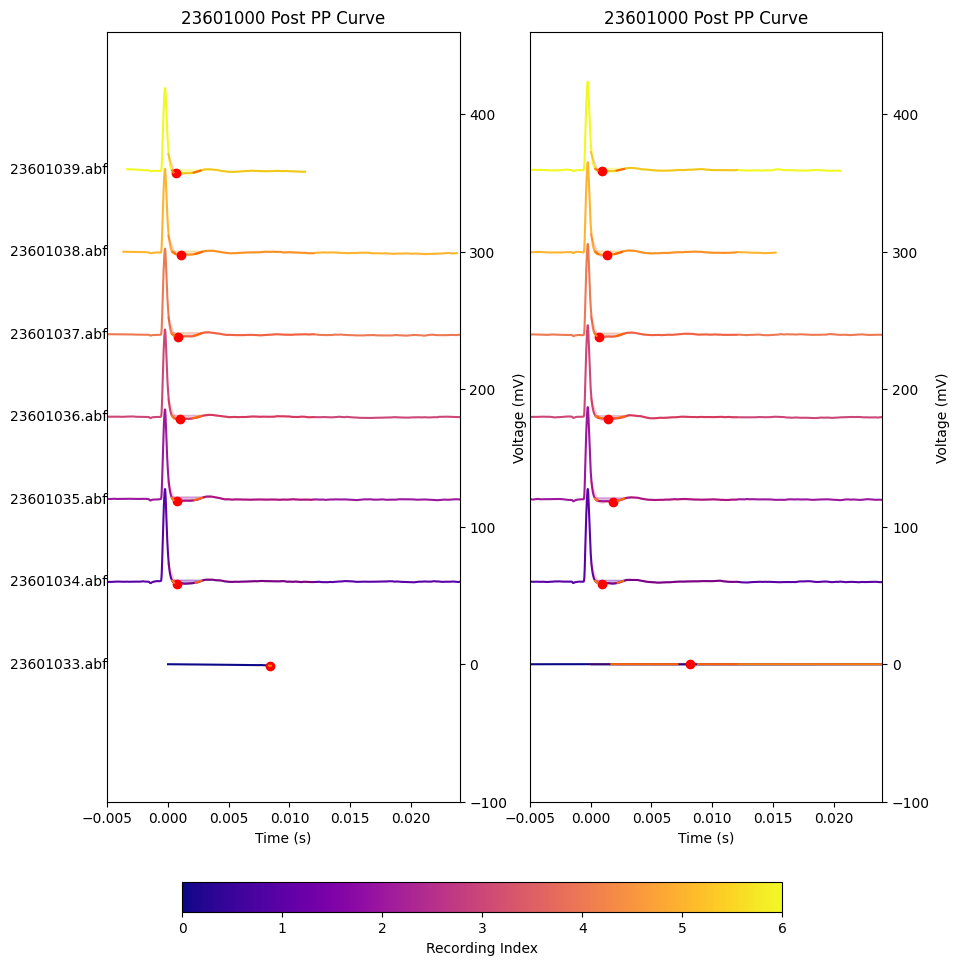

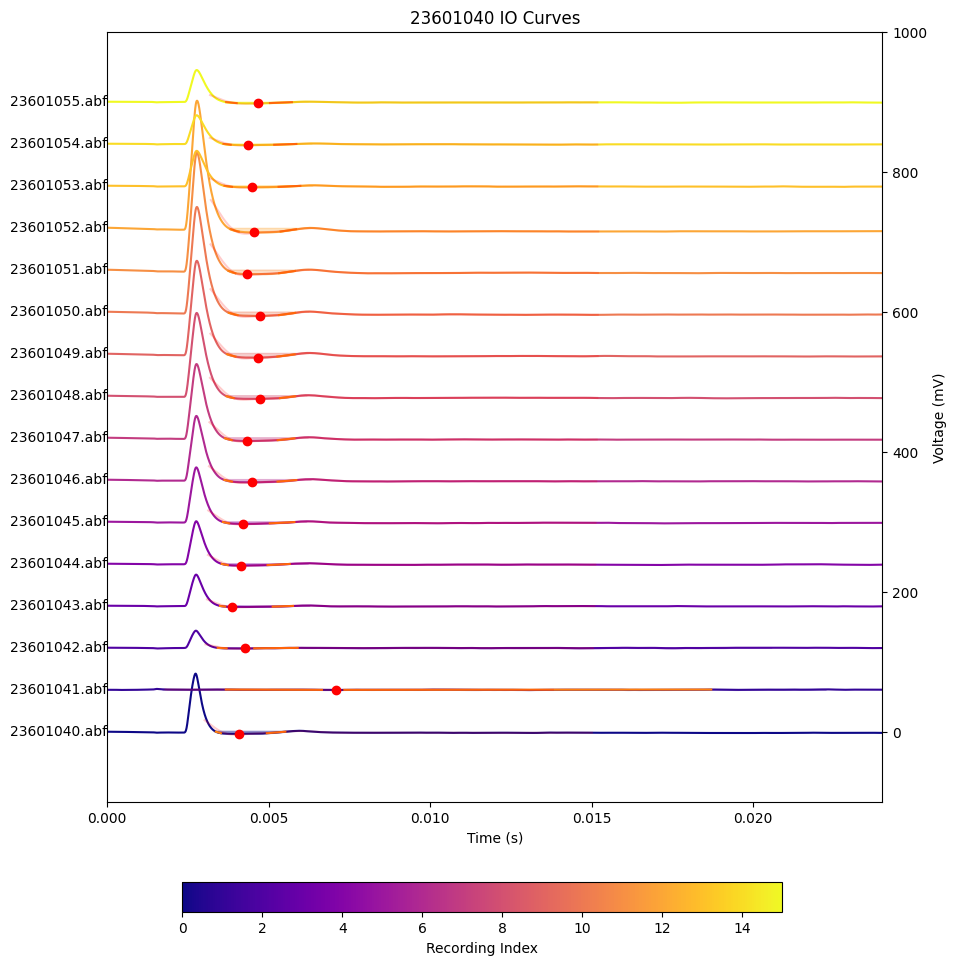

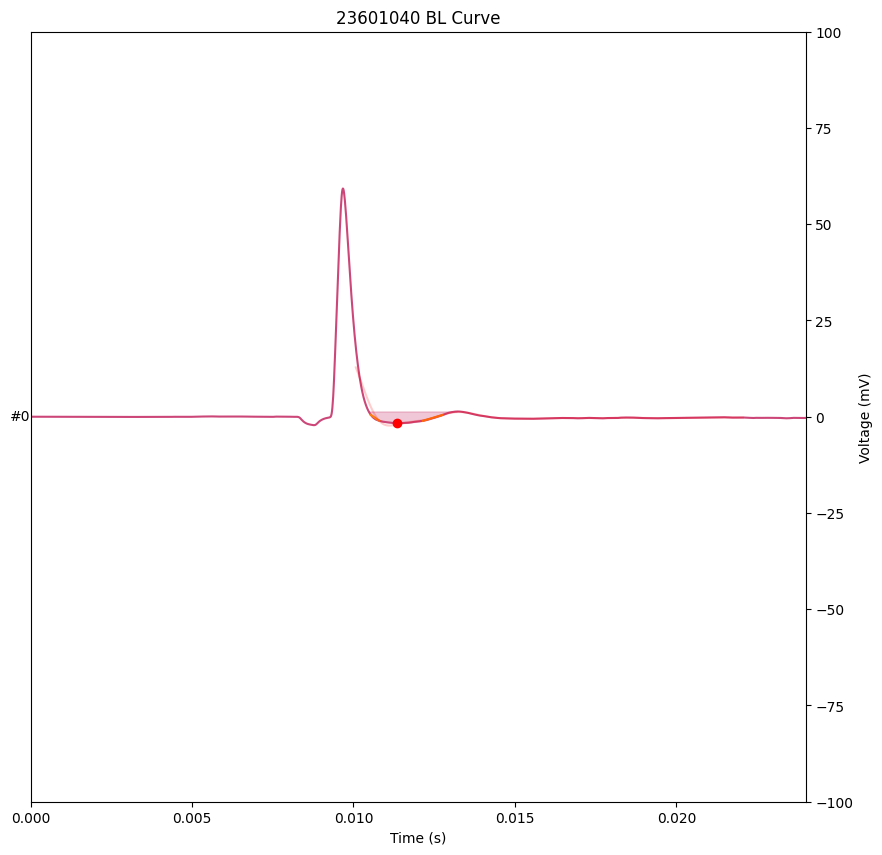

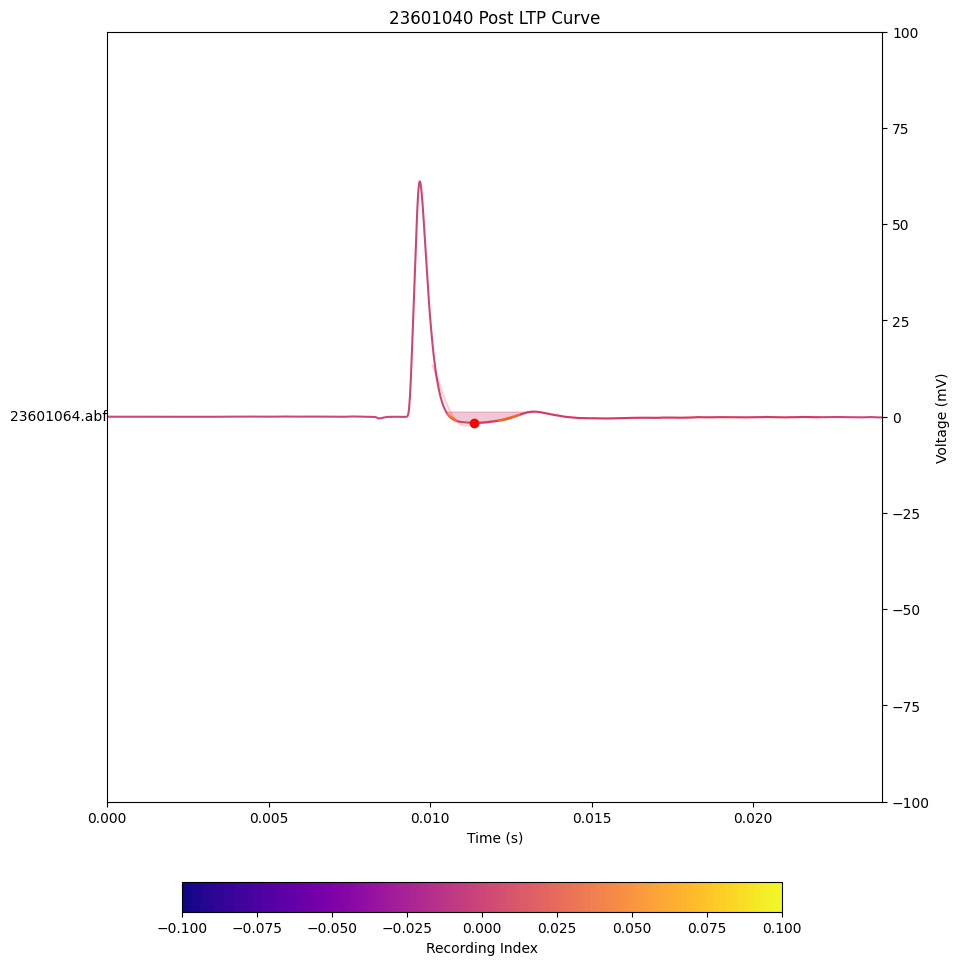

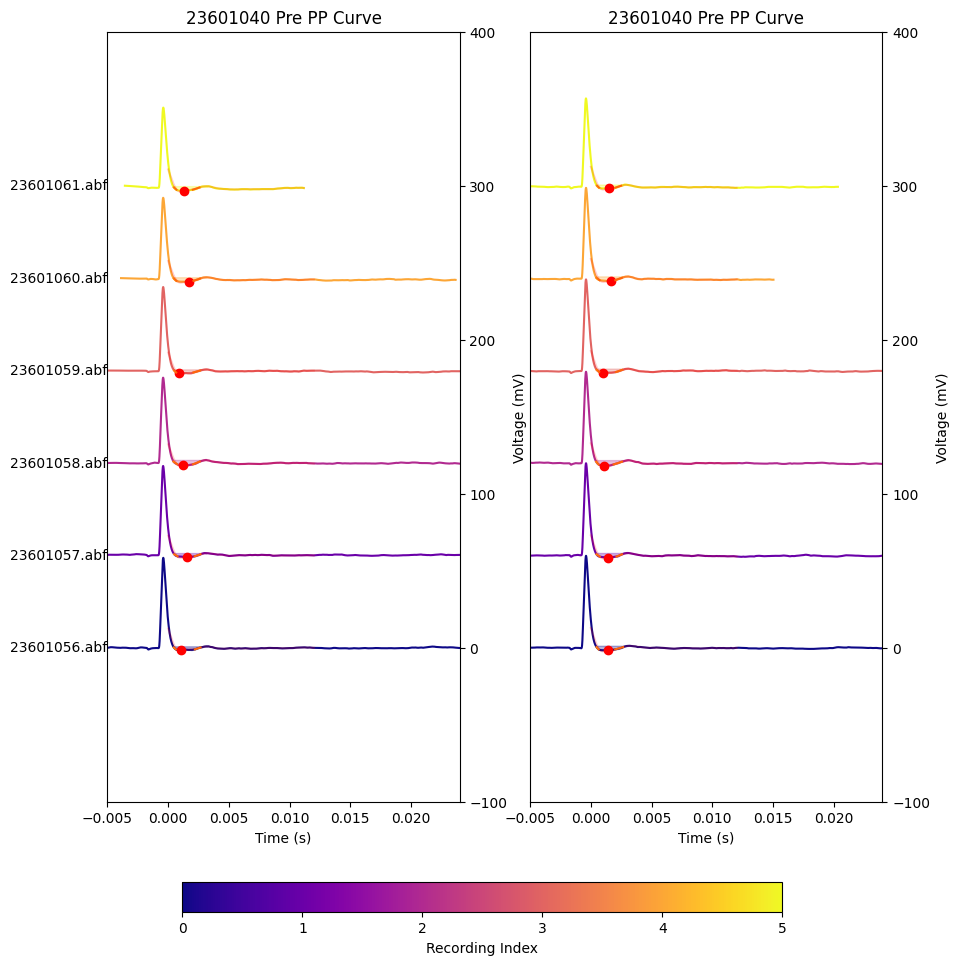

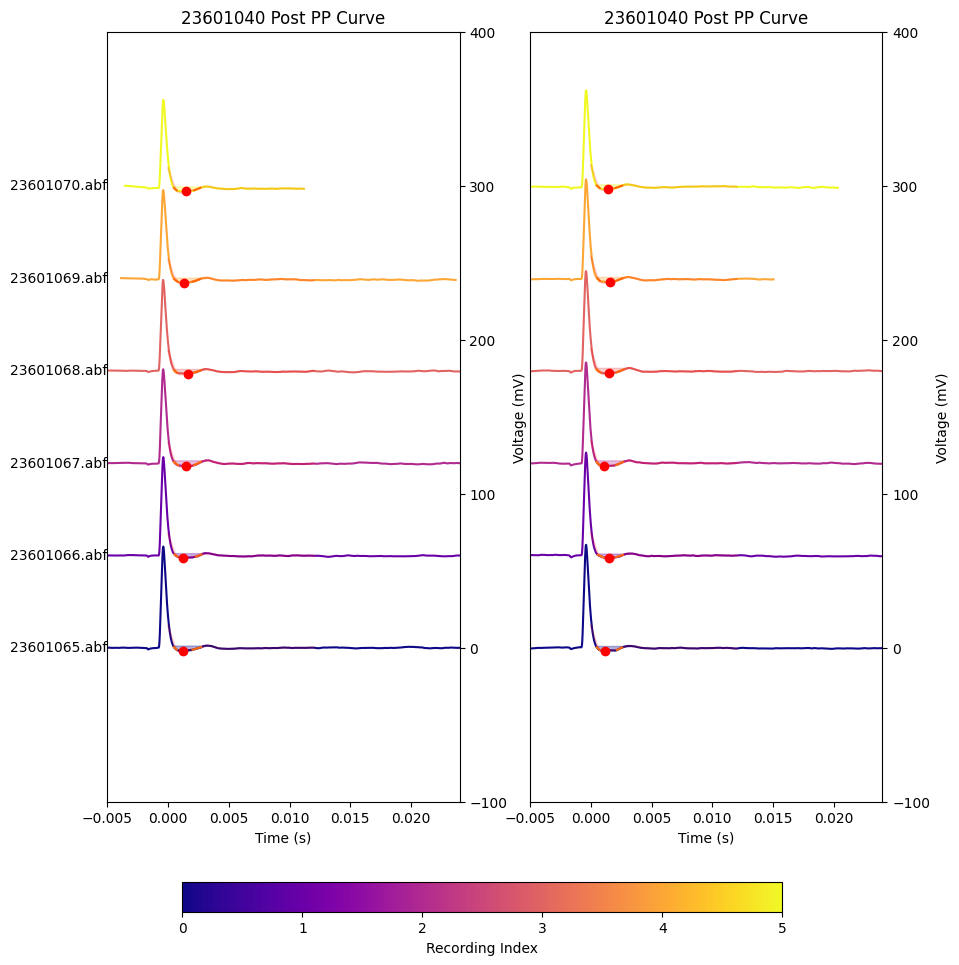

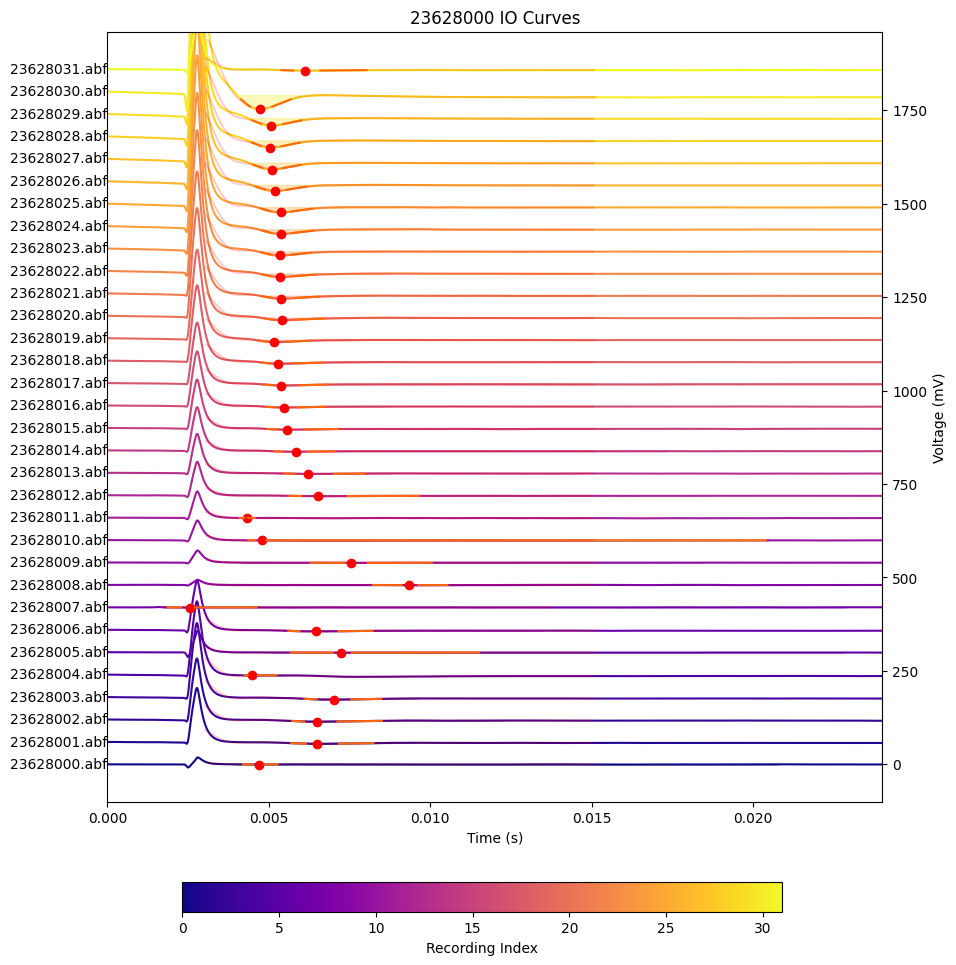

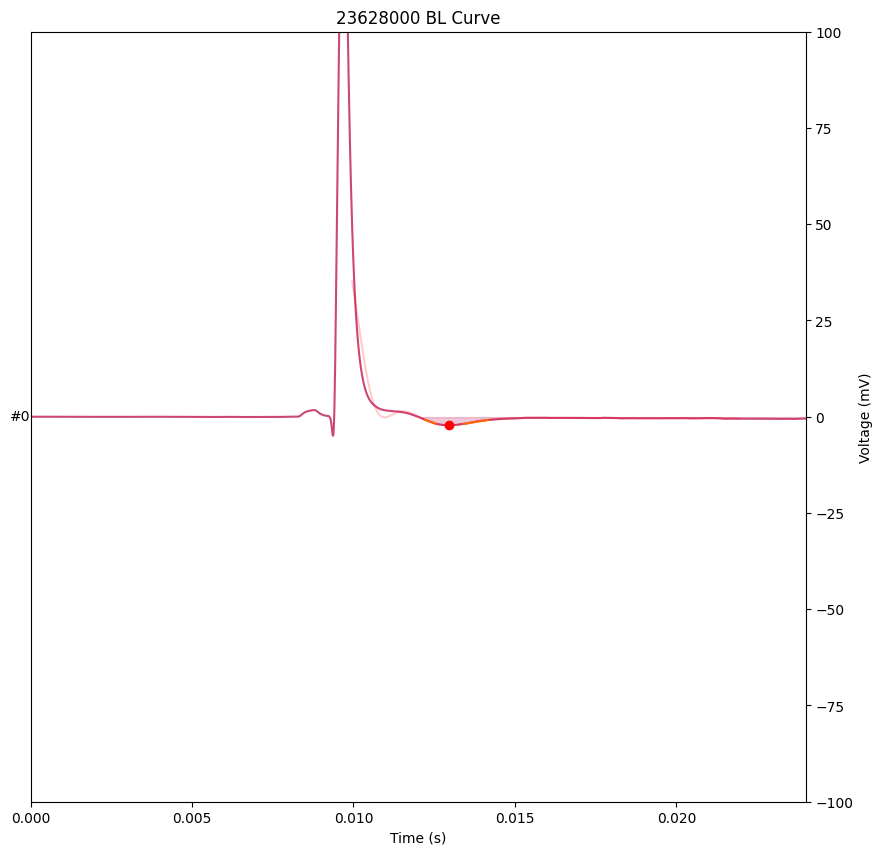

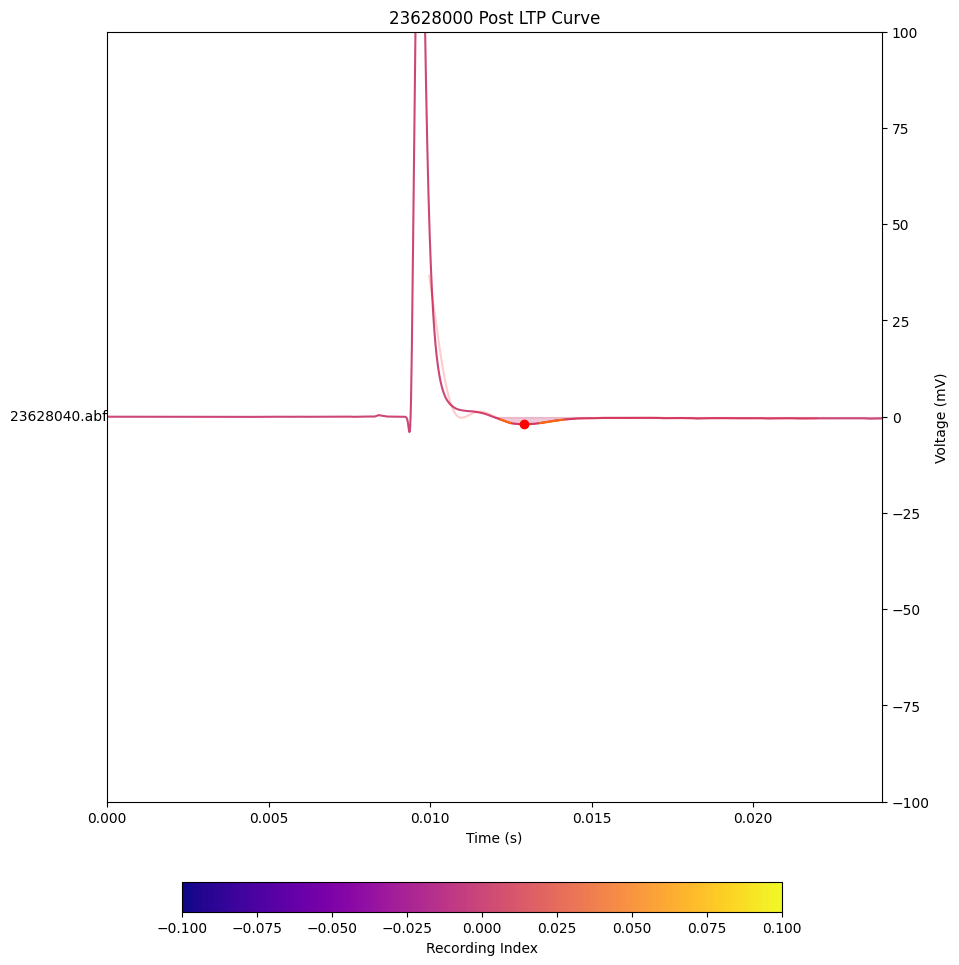

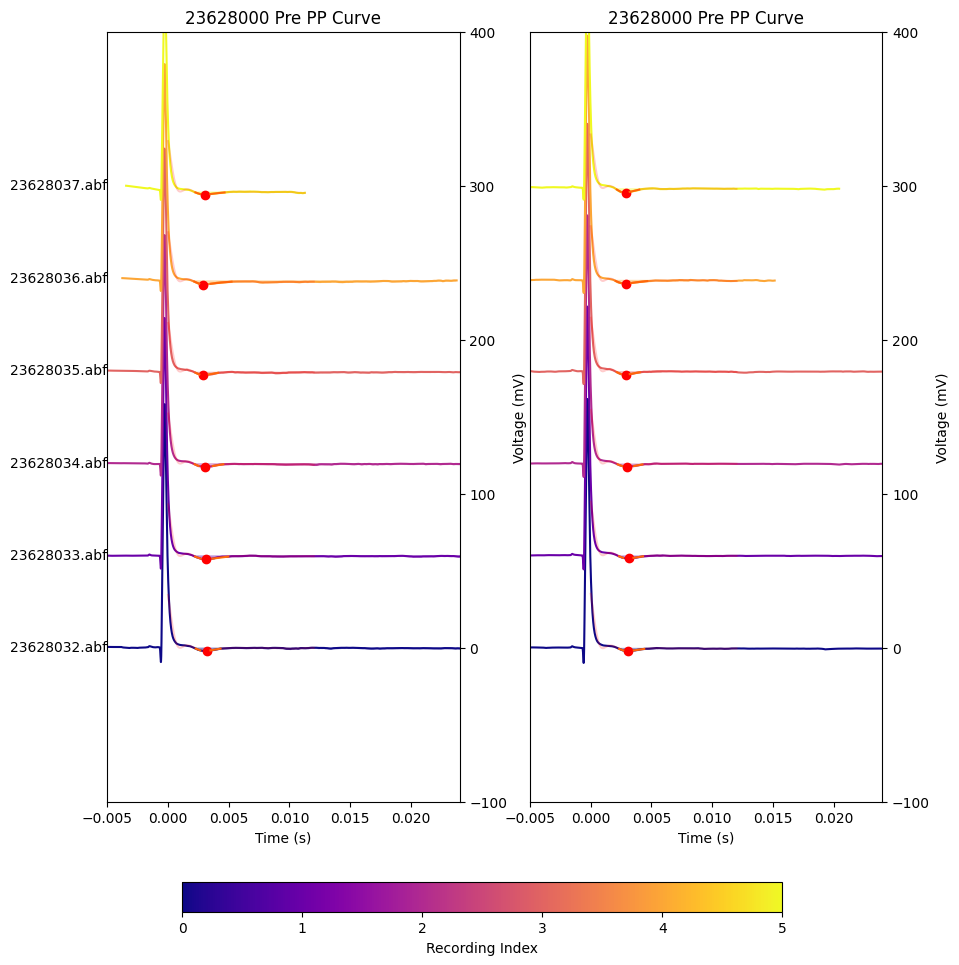

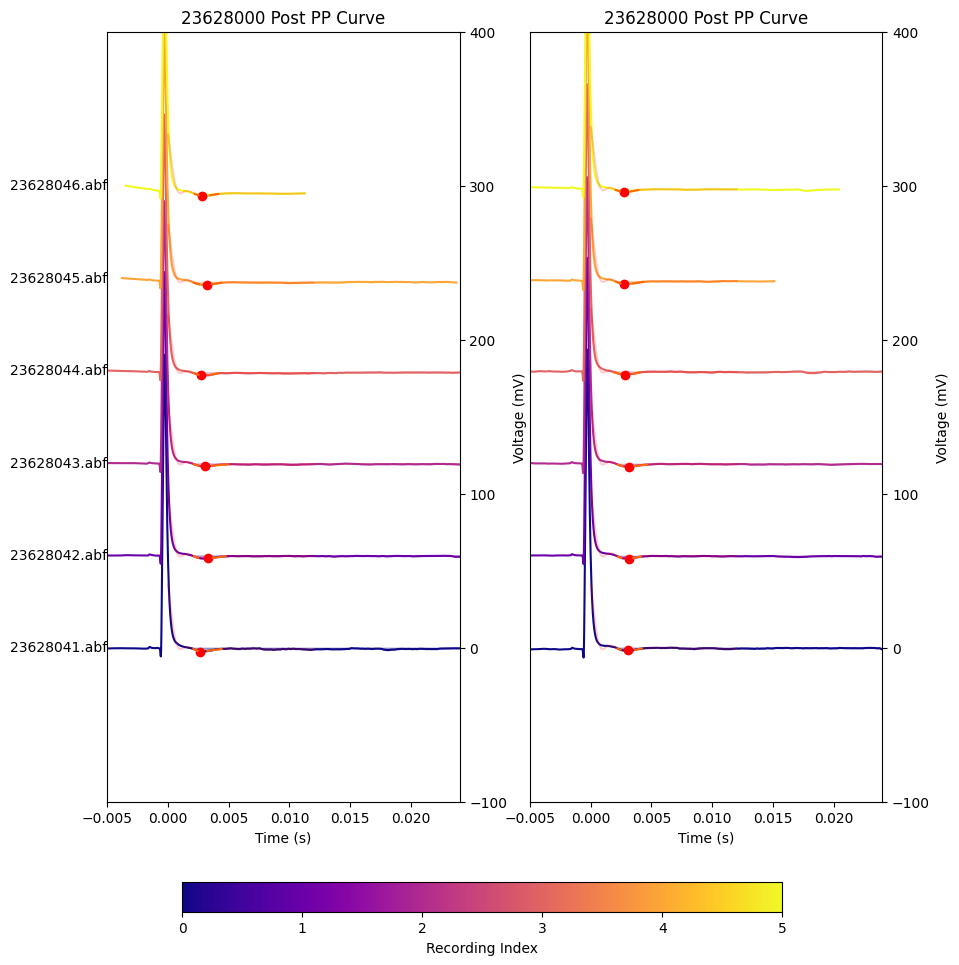

/tmp/ipykernel_2353744/2608634758.py:343: UserWarning: Could not find baseline crossings before peak. Using max before peak
  warnings.warn("Could not find baseline crossings before peak. Using max before peak")


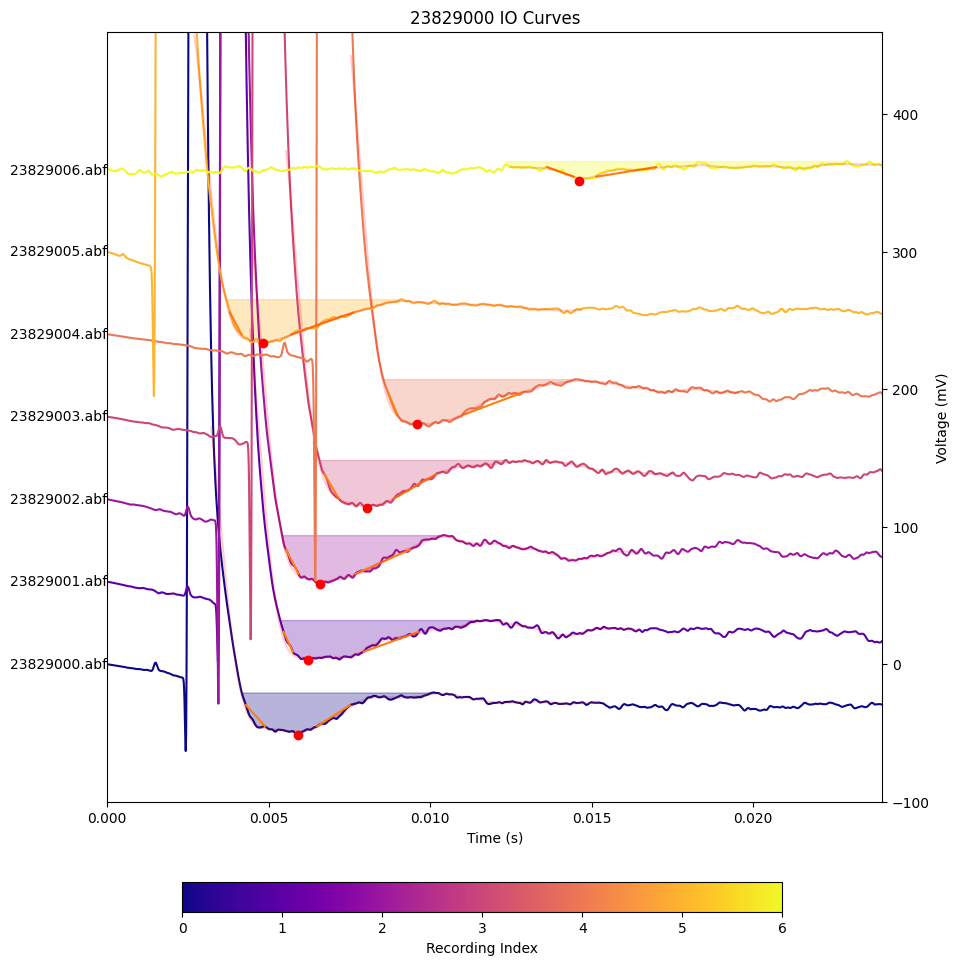

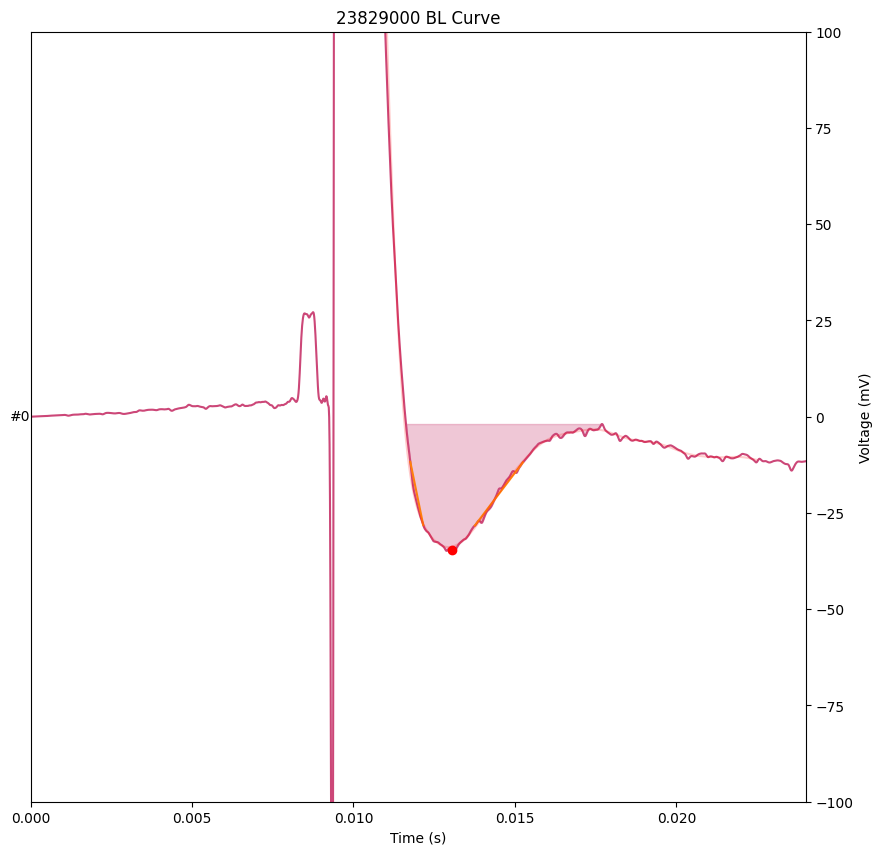

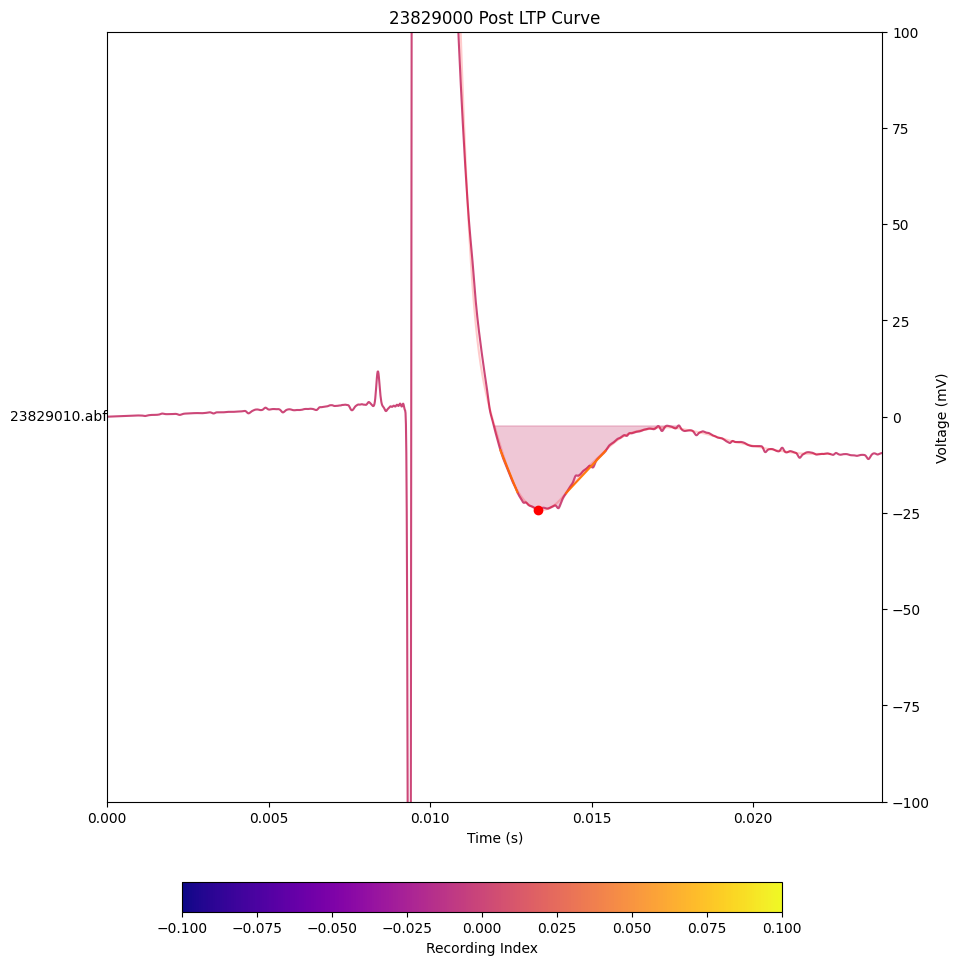

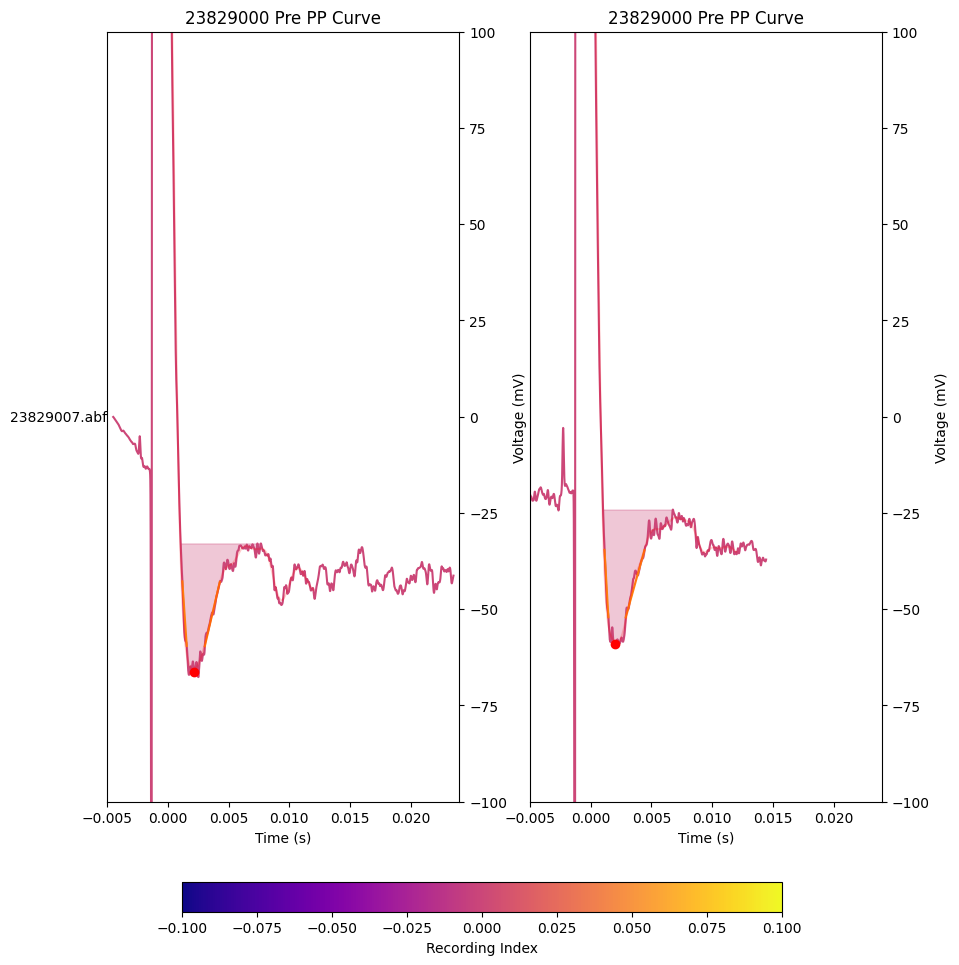

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['BL', 'I-O', 'LTP', 'Post LTP', 'Pre PP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


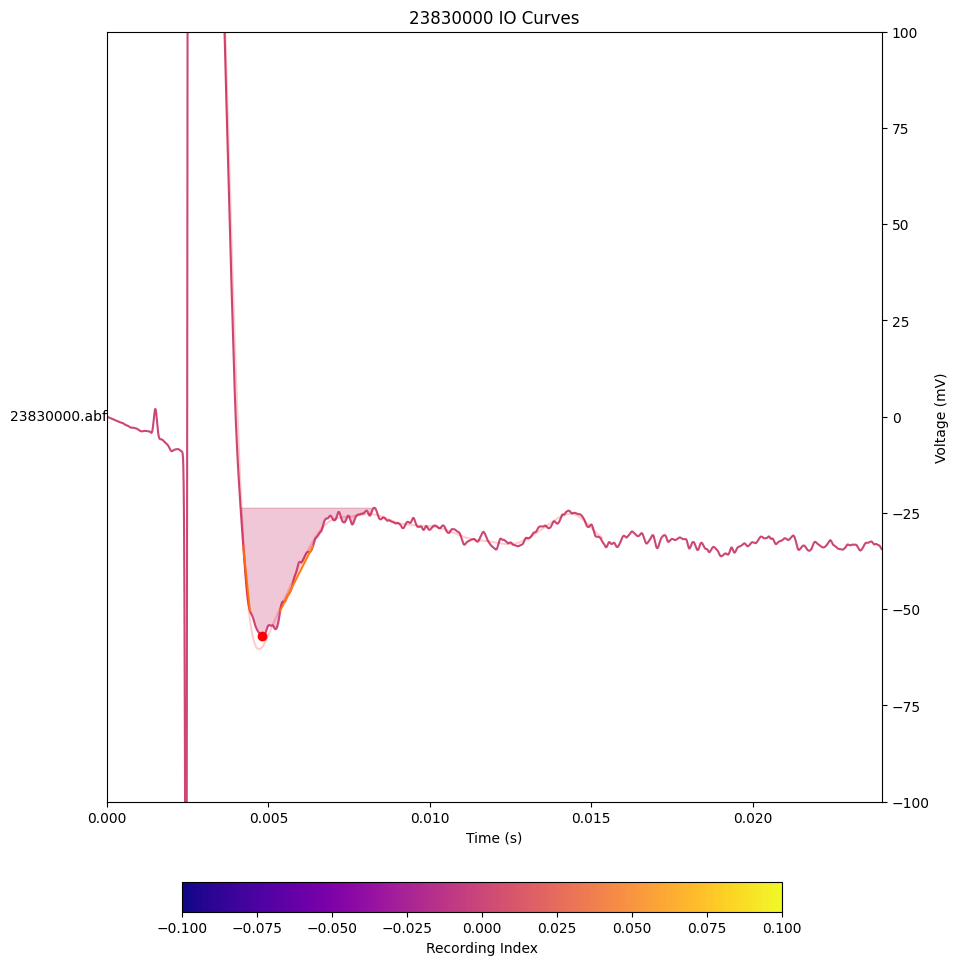

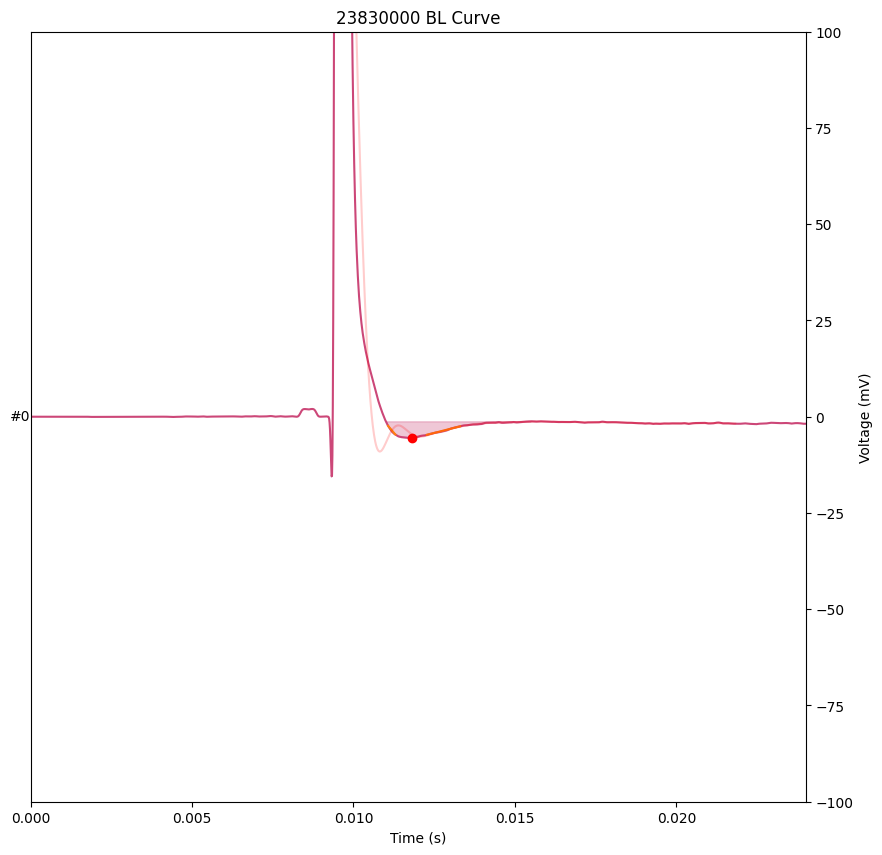

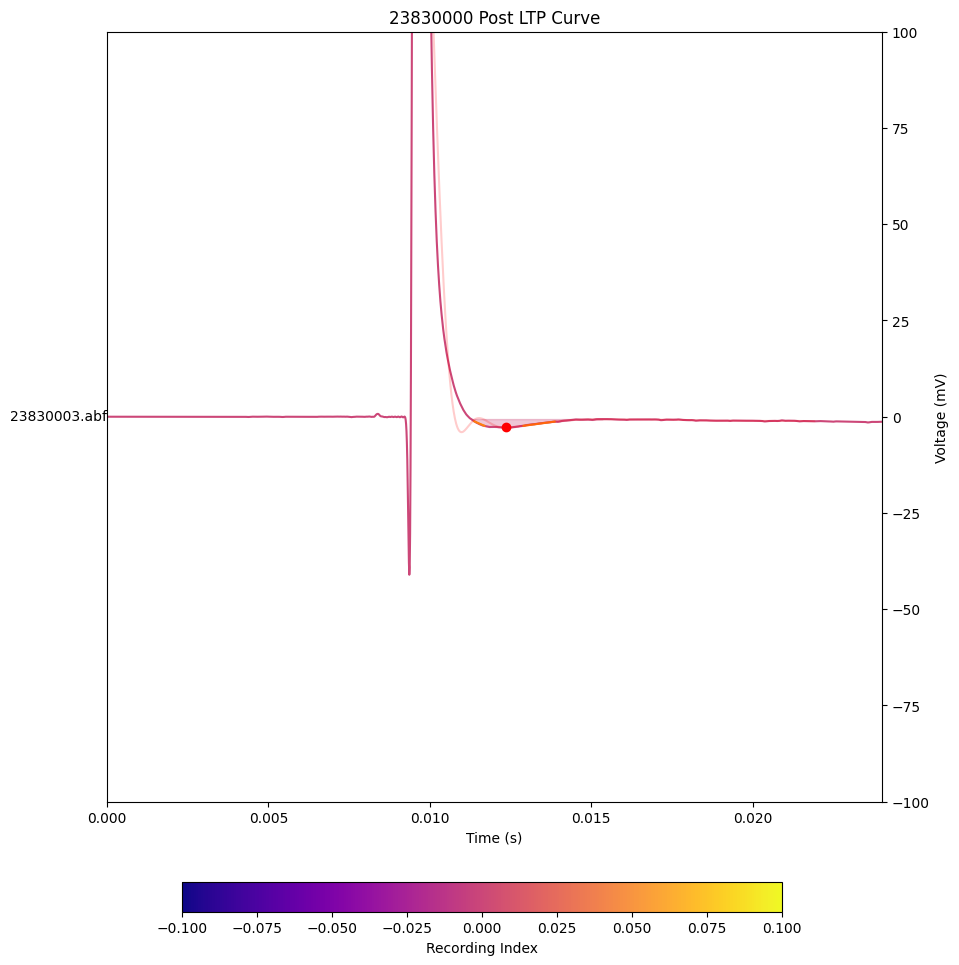

/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Pre PP recordings found in ['23830000-3 4x.jpg', 'BL', 'I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')
/tmp/ipykernel_2353744/1325616311.py:16: UserWarning: No Post PP recordings found in ['23830000-3 4x.jpg', 'BL', 'I-O', 'LTP', 'Post LTP']
  warnings.warn(f'No {item_name} recordings found in {self.subfolder_item_names}')


In [28]:
# for folder in ['24220000']:
# for folder in ['23614045']:
for i, folder in enumerate(folders):

    # save_path = Path(f'/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/xlsx_output_2-17-25_single/{folder}')
    # sp = SlicePlotter('/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/LTP & IO', 
    #                   folder,
    #                   compute_single_sweeps=True, 
    #                   y_rec_spacing=60,
    #                   y_sweep_spacing=30,
    #                   savepath=save_path)
    save_path = Path(f'/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/xlsx_output_2-17-25_avg/{folder}')
    sp = SlicePlotter('/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/LTP & IO', 
                      folder,
                      compute_single_sweeps=False, 
                      y_rec_spacing=60,
                      y_sweep_spacing=30,
                      auto_ylim_margin=100,
                      cmap=sns.color_palette("plasma", as_cmap=True),
                      savepath=save_path)
    os.makedirs(save_path, exist_ok=True)

    sp.compute_all_io(figsize=(10, 10))
    sp.compute_all_bl(figsize=(10, 10))
    sp.compute_all_post_ltp(figsize=(10, 10))
    sp.compute_all_ppr('Pre PP', figsize=(10, 10))
    sp.compute_all_ppr('Post PP', figsize=(10, 10))

    for df in ['io', 'bl', 'post_ltp', 'pre_ppr', 'post_ppr']:
        if hasattr(sp, f'df_{df}'):
            df_path = save_path / f'{df}.xlsx'
            getattr(sp, f'df_{df}').to_excel(df_path, index=False)


    # break
    # if i == 2:
    #     break


In [29]:
display(sp.df_bl)

original_trace-V  \
0  [-0.47912598, -0.445048, -0.47098795, -0.31992...   

                                    original_trace-t  \
0  [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...   

                                   processed_trace-V  \
0  [0.00020814116343374902, 0.0003018270037708212...   

                                   processed_trace-t  stim_onset  \
0  [0.0, 1.2499062476561915e-05, 2.49981249531238...    0.009837   

   stim_onset_idx  baseline  baseline_idx      peak  peak_idx  ...  \
0             787 -1.191728           297 -5.549004       944  ...   

   thresholds-high  30-80_slope-before  30-80_slope-after  amplitude  \
0        -4.677549       -10006.425022        2142.002053  -4.357275   

       area  baseline_crossings-before_idx  baseline_crossings-after_idx  \
0 -0.013395                            880                          1240   

   recording_name  recording_index  sweep_index  
0    23830001.abf                0            0  

[1 rows x 23 columns]

In [30]:
# %%script true
# cf = ChrisFPAReader('/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/LTP & IO', '23601000')
# n_sweeps = cf.get_abf_subfolder_subitem_num_sweeps('I-O')
# fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# for i in range(n_sweeps):
#     V, t, f_s = cf.load_abf_one_index('I-O', i)

#     tf = TraceFitter(V, t, f_s)
#     tf.fit_trace()
#     out = tf.get_trace_fit_params()
    
#     peak_idx = out['peak_idx']
#     V = -out['processed_trace']['V']
#     t = out['processed_trace']['t']

#     offset = i * 3
#     # Create colormap based on sweep number
#     colors = plt.cm.viridis(i/n_sweeps)
#     ax.plot(t, -V + offset, color=colors)
#     ax.plot(t[peak_idx], -V[peak_idx] + offset, 'ro', label='Peak')

#     idx1, idx2 = tf._get_threshold_crossings_near_spike('before')
#     idx1 = idx1[0]
#     idx2 = idx2[0]
#     ax.plot([t[idx1], t[idx2]], np.array([-V[idx1], -V[idx2]]) + offset, c='C1')

#     idx1, idx2 = tf._get_threshold_crossings_near_spike('after')
#     idx1 = idx1[0]
#     idx2 = idx2[0]
#     ax.plot([t[idx1], t[idx2]], np.array([-V[idx1], -V[idx2]]) + offset, c='C1')
            
#     # Fill area between baseline and trace for the spike region
#     before_idx1 = tf.get_trace_fit_params()['baseline_crossings']['before_idx']
#     after_idx1 = tf.get_trace_fit_params()['baseline_crossings']['after_idx']
    
#     baseline = out['baseline']
#     ax.fill_between(t[before_idx1:after_idx1],
#                    baseline + offset,
#                    -V[before_idx1:after_idx1] + offset,
#                    color=colors,
#                    alpha=0.3)

# # Add colorbar
# display(tf.get_trace_fit_params_df())
# sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(0, n_sweeps-1))
# plt.colorbar(sm, ax=ax, label='Sweep Number')
# plt.show()
